# **IPL Data Analysis and 2025 winner prediction model**

This notebook presents a comprehensive analysis of Indian Premier League (IPL) data from the inception of the league in 2008 through to the most recent season in 2024, with the goal of uncovering key insights, trends, and patterns within the data. It includes data collection and preprocessing steps, exploratory data analysis (EDA) to visualize key metrics such as win rates, player performance, and team statistics, and statistical insights to identify significant factors influencing match outcomes. The notebook then introduces a Random Forest Classification model to predict the winner of the 2025 IPL season, explaining the model’s features, training, validation, and performance evaluation. The results section presents the model’s predictions for the 2025 season, discusses the potential strengths and limitations of the model, and provides insights into the predicted performance of teams and key players. The primary objective is to leverage historical IPL data to build a predictive model that forecasts future match outcomes, offering a data-driven prediction for the 2025 IPL winner while illustrating the application of machine learning techniques to real-world sports data.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-complete-dataset-20082020/matches.csv
/kaggle/input/ipl-complete-dataset-20082020/deliveries.csv


In [2]:
deliveries_df = pd.read_csv('/kaggle/input/ipl-complete-dataset-20082020/deliveries.csv')
matches_df = pd.read_csv('/kaggle/input/ipl-complete-dataset-20082020/matches.csv')

print("Deliveries shape:", deliveries_df.shape)
print("Matches shape:", matches_df.shape)

deliveries = deliveries_df.copy()
matches = matches_df.copy()

Deliveries shape: (260920, 17)
Matches shape: (1095, 20)


# **IPL 2008 - 2024 Data Analysis**

In [3]:
matches.head()

id   season        city        date match_type player_of_match  \
0  335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1  335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2  335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3  335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4  335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner toss_decision  \
0        Kolkata Knight Riders  Royal Challengers Bangalore         field   
1          Chennai Super Kings          Chennai Super Kings           bat   
2             Rajasthan Royals             Rajasthan Royals           bat   
3  Royal Challengers Bangalore               Mumbai Indians           bat   
4              Deccan Chargers              Deccan Chargers           bat   

                        winner   result  result_margin  target_runs  \
0        Kolkata Knight Riders     runs          140.0        223.0   
1          Chennai Super Kings     runs           33.0        241.0   
2             Delhi Daredevils  wickets            9.0        130.0   
3  Royal Challengers Bangalore  wickets            5.0        166.0   
4        Kolkata Knight Riders  wickets            5.0        111.0   

   target_overs super_over method    umpire1         umpire2  
0          20.0          N    NaN  Asad Rauf     RE Koertzen  
1          20.0          N    NaN  MR Benson      SL Shastri  
2          20.0          N    NaN  Aleem Dar  GA Pratapkumar  
3          20.0          N    NaN   SJ Davis       DJ Harper  
4          20.0          N    NaN  BF Bowden     K Hariharan

In [4]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1095 non-null   int64  
 1   season           1095 non-null   object 
 2   city             1044 non-null   object 
 3   date             1095 non-null   object 
 4   match_type       1095 non-null   object 
 5   player_of_match  1090 non-null   object 
 6   venue            1095 non-null   object 
 7   team1            1095 non-null   object 
 8   team2            1095 non-null   object 
 9   toss_winner      1095 non-null   object 
 10  toss_decision    1095 non-null   object 
 11  winner           1090 non-null   object 
 12  result           1095 non-null   object 
 13  result_margin    1076 non-null   float64
 14  target_runs      1092 non-null   float64
 15  target_overs     1092 non-null   float64
 16  super_over       1095 non-null   object 
 17  method        

In [5]:
matches.describe()

id  result_margin  target_runs  target_overs
count  1.095000e+03    1076.000000  1092.000000   1092.000000
mean   9.048283e+05      17.259294   165.684066     19.759341
std    3.677402e+05      21.787444    33.427048      1.581108
min    3.359820e+05       1.000000    43.000000      5.000000
25%    5.483315e+05       6.000000   146.000000     20.000000
50%    9.809610e+05       8.000000   166.000000     20.000000
75%    1.254062e+06      20.000000   187.000000     20.000000
max    1.426312e+06     146.000000   288.000000     20.000000

### **Data Cleaning**

In [6]:
# Drop rows with missing values in the 'winner' column
matches = matches.dropna(subset=['winner'])

In [7]:
# Impute missing valuse in 'player_of_match'
matches['player_of_match'] = matches['player_of_match'].fillna('Unknown')

In [8]:
# Drop unwanted columns from the dataset
matches.drop(['id', 'city', 'method'], axis=1, inplace=True)

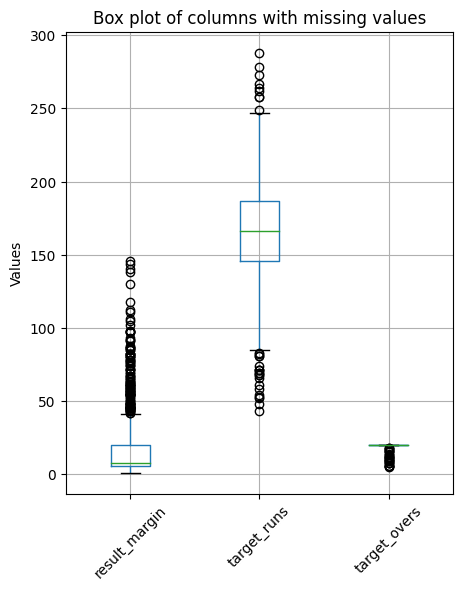

In [9]:
import matplotlib.pyplot as plt

columns_to_handle_missing = ['result_margin', 'target_runs', 'target_overs']

# Plot box plots for each column
plt.figure(figsize=(5, 6))
matches[columns_to_handle_missing].boxplot()
plt.title('Box plot of columns with missing values')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Impute selected columns with median because they have outliers

matches['result_margin'] = matches['result_margin'].fillna(matches['result_margin'].median())
matches['target_runs'] = matches['target_runs'].fillna(matches['target_runs'].median())
matches['target_overs'] = matches['target_overs'].fillna(matches['target_overs'].median())

In [11]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090 entries, 0 to 1094
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           1090 non-null   object 
 1   date             1090 non-null   object 
 2   match_type       1090 non-null   object 
 3   player_of_match  1090 non-null   object 
 4   venue            1090 non-null   object 
 5   team1            1090 non-null   object 
 6   team2            1090 non-null   object 
 7   toss_winner      1090 non-null   object 
 8   toss_decision    1090 non-null   object 
 9   winner           1090 non-null   object 
 10  result           1090 non-null   object 
 11  result_margin    1090 non-null   float64
 12  target_runs      1090 non-null   float64
 13  target_overs     1090 non-null   float64
 14  super_over       1090 non-null   object 
 15  umpire1          1090 non-null   object 
 16  umpire2          1090 non-null   object 
dtypes: float64(3), obje

In [12]:
matches.nunique()

season              17
date               821
match_type           8
player_of_match    291
venue               58
team1               19
team2               19
toss_winner         19
toss_decision        2
winner              19
result               3
result_margin       98
target_runs        169
target_overs        15
super_over           2
umpire1             62
umpire2             62
dtype: int64

### **Feature Engineering**

In [13]:
# Extract date features
matches['date'] = pd.to_datetime(matches['date'])
matches['year'] = matches['date'].dt.year
matches['month'] = matches['date'].dt.month
matches['day'] = matches['date'].dt.day

# Drop the original date column
matches.drop('date', axis=1, inplace=True)

In [14]:
# Function to split season values
def split_season(season):
    if '/' in season:
        start, end = season.split('/')
        start = int(start)
        end = int('20' + end) if len(end) == 2 else int(end)
    else:
        start = end = int(season)
    return start, end

# Apply the function to create new columns
matches[['season_start', 'season_end']] = matches['season'].apply(lambda x: pd.Series(split_season(x)))

# Convert to datetime and extract year
matches['season_start'] = pd.to_datetime(matches['season_start'], format='%Y').dt.year
matches['season_end'] = pd.to_datetime(matches['season_end'], format='%Y').dt.year

# Drop the original 'season' column
# matches.drop('season', axis=1, inplace=True)

In [15]:
matches['winner'].unique()

array(['Kolkata Knight Riders', 'Chennai Super Kings', 'Delhi Daredevils',
       'Royal Challengers Bangalore', 'Rajasthan Royals',
       'Kings XI Punjab', 'Deccan Chargers', 'Mumbai Indians',
       'Pune Warriors', 'Kochi Tuskers Kerala', 'Sunrisers Hyderabad',
       'Rising Pune Supergiants', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Gujarat Titans', 'Lucknow Super Giants',
       'Royal Challengers Bengaluru'], dtype=object)

In [16]:
# Mapping dictionary for old names to standardized names
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings',
    'Rising Pune Supergiants': 'Pune Warriors',
    'Rising Pune Supergiant': 'Pune Warriors',
    'Gujarat Lions': 'Gujarat Titans',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Royal Challengers Bengaluru': 'Royal Challengers Bangalore',
}

team_columns = ['winner', 'team1', 'team2', 'toss_winner']

# Replace the team names in the 'winner' column
matches[team_columns] = matches[team_columns].replace(team_name_mapping)

In [17]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1090 entries, 0 to 1094
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           1090 non-null   object 
 1   match_type       1090 non-null   object 
 2   player_of_match  1090 non-null   object 
 3   venue            1090 non-null   object 
 4   team1            1090 non-null   object 
 5   team2            1090 non-null   object 
 6   toss_winner      1090 non-null   object 
 7   toss_decision    1090 non-null   object 
 8   winner           1090 non-null   object 
 9   result           1090 non-null   object 
 10  result_margin    1090 non-null   float64
 11  target_runs      1090 non-null   float64
 12  target_overs     1090 non-null   float64
 13  super_over       1090 non-null   object 
 14  umpire1          1090 non-null   object 
 15  umpire2          1090 non-null   object 
 16  year             1090 non-null   int32  
 17  month            10

# Feature Extraction from the matches dataset

In [18]:
matches.head()

season match_type player_of_match  \
0  2007/08     League     BB McCullum   
1  2007/08     League      MEK Hussey   
2  2007/08     League     MF Maharoof   
3  2007/08     League      MV Boucher   
4  2007/08     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali                 Punjab Kings   
2                            Feroz Shah Kotla               Delhi Capitals   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner toss_decision  \
0        Kolkata Knight Riders  Royal Challengers Bangalore         field   
1          Chennai Super Kings          Chennai Super Kings           bat   
2             Rajasthan Royals             Rajasthan Royals           bat   
3  Royal Challengers Bangalore               Mumbai Indians           bat   
4          Sunrisers Hyderabad          Sunrisers Hyderabad           bat   

                        winner   result  ...  target_runs  target_overs  \
0        Kolkata Knight Riders     runs  ...        223.0          20.0   
1          Chennai Super Kings     runs  ...        241.0          20.0   
2               Delhi Capitals  wickets  ...        130.0          20.0   
3  Royal Challengers Bangalore  wickets  ...        166.0          20.0   
4        Kolkata Knight Riders  wickets  ...        111.0          20.0   

   super_over    umpire1         umpire2  year  month  day  season_start  \
0           N  Asad Rauf     RE Koertzen  2008      4   18          2007   
1           N  MR Benson      SL Shastri  2008      4   19          2007   
2           N  Aleem Dar  GA Pratapkumar  2008      4   19          2007   
3           N   SJ Davis       DJ Harper  2008      4   20          2007   
4           N  BF Bowden     K Hariharan  2008      4   20          2007   

   season_end  
0        2008  
1        2008  
2        2008  
3        2008  
4        2008  

[5 rows x 21 columns]

In [19]:
teams = pd.concat([matches['team1'], matches['team2']]).unique()
team_stats = pd.DataFrame(teams, columns=['team_name'])

team_stats

team_name
0   Royal Challengers Bangalore
1                  Punjab Kings
2                Delhi Capitals
3                Mumbai Indians
4         Kolkata Knight Riders
5              Rajasthan Royals
6           Sunrisers Hyderabad
7           Chennai Super Kings
8          Kochi Tuskers Kerala
9                 Pune Warriors
10               Gujarat Titans
11         Lucknow Super Giants

In [20]:
# Calculate matches played and won
team_stats['matches_played'] = team_stats['team_name'].apply(lambda x: len(matches[(matches['team1'] == x) | (matches['team2'] == x)]))
team_stats['matches_won'] = team_stats['team_name'].apply(lambda x: len(matches[matches['winner'] == x]))
team_stats['win_percentage'] = (team_stats['matches_won'] / team_stats['matches_played']) * 100

team_stats

team_name  matches_played  matches_won  win_percentage
0   Royal Challengers Bangalore             252          123       48.809524
1                  Punjab Kings             246          112       45.528455
2                Delhi Capitals             250          115       46.000000
3                Mumbai Indians             261          144       55.172414
4         Kolkata Knight Riders             251          131       52.191235
5              Rajasthan Royals             219          112       51.141553
6           Sunrisers Hyderabad             257          117       45.525292
7           Chennai Super Kings             237          138       58.227848
8          Kochi Tuskers Kerala              14            6       42.857143
9                 Pune Warriors              75           27       36.000000
10               Gujarat Titans              75           41       54.666667
11         Lucknow Super Giants              43           24       55.813953

In [21]:
team_stats['total_runs_scored'] = team_stats['team_name'].apply(lambda x: matches[matches['team1'] == x]['target_runs'].sum() + matches[matches['team2'] == x]['target_runs'].sum())
team_stats['total_wickets_taken'] = team_stats['team_name'].apply(lambda x: matches[matches['team1'] == x]['target_overs'].sum() + matches[matches['team2'] == x]['target_overs'].sum())

team_stats['total_runs_scored'] = team_stats['total_runs_scored'].astype(int)
team_stats['total_wickets_taken'] = team_stats['total_wickets_taken'].astype(int)

team_stats

team_name  matches_played  matches_won  win_percentage  \
0   Royal Challengers Bangalore             252          123       48.809524   
1                  Punjab Kings             246          112       45.528455   
2                Delhi Capitals             250          115       46.000000   
3                Mumbai Indians             261          144       55.172414   
4         Kolkata Knight Riders             251          131       52.191235   
5              Rajasthan Royals             219          112       51.141553   
6           Sunrisers Hyderabad             257          117       45.525292   
7           Chennai Super Kings             237          138       58.227848   
8          Kochi Tuskers Kerala              14            6       42.857143   
9                 Pune Warriors              75           27       36.000000   
10               Gujarat Titans              75           41       54.666667   
11         Lucknow Super Giants              43           24       55.813953   

    total_runs_scored  total_wickets_taken  
0               42542                 4975  
1               41178                 4854  
2               41234                 4920  
3               43728                 5214  
4               40557                 4907  
5               36187                 4358  
6               42118                 5080  
7               39503                 4693  
8                2014                  277  
9               11514                 1471  
10              12942                 1495  
11               7835                  860

In [22]:
team_stats['average_runs_scored_per_match'] = team_stats['total_runs_scored'] / team_stats['matches_played']
team_stats['run_rate'] = team_stats['team_name'].apply(lambda x: deliveries[deliveries['batting_team'] == x]['total_runs'].sum() / (deliveries[deliveries['batting_team'] == x].shape[0] / 6))
team_stats['economy_rate'] = team_stats['team_name'].apply(lambda x: deliveries[deliveries['bowling_team'] == x]['total_runs'].sum() / (deliveries[deliveries['bowling_team'] == x].shape[0] / 6))

team_stats

team_name  matches_played  matches_won  win_percentage  \
0   Royal Challengers Bangalore             252          123       48.809524   
1                  Punjab Kings             246          112       45.528455   
2                Delhi Capitals             250          115       46.000000   
3                Mumbai Indians             261          144       55.172414   
4         Kolkata Knight Riders             251          131       52.191235   
5              Rajasthan Royals             219          112       51.141553   
6           Sunrisers Hyderabad             257          117       45.525292   
7           Chennai Super Kings             237          138       58.227848   
8          Kochi Tuskers Kerala              14            6       42.857143   
9                 Pune Warriors              75           27       36.000000   
10               Gujarat Titans              75           41       54.666667   
11         Lucknow Super Giants              43           24       55.813953   

    total_runs_scored  total_wickets_taken  average_runs_scored_per_match  \
0               42542                 4975                     168.817460   
1               41178                 4854                     167.390244   
2               41234                 4920                     164.936000   
3               43728                 5214                     167.540230   
4               40557                 4907                     161.581673   
5               36187                 4358                     165.237443   
6               42118                 5080                     163.883268   
7               39503                 4693                     166.679325   
8                2014                  277                     143.857143   
9               11514                 1471                     153.520000   
10              12942                 1495                     172.560000   
11               7835                  860                     182.209302   

    run_rate  economy_rate  
0   8.018153      8.036039  
1   8.373482      8.523590  
2   8.167367      8.235556  
3   8.049623      7.864656  
4   7.995731      7.906011  
5   7.944593      7.977149  
6   7.985442      8.040613  
7   8.089561      7.812220  
8   7.209861      7.382900  
9   7.008635      7.539307  
10  8.471423      8.460668  
11  8.344444      8.513203

In [23]:
# Exclude no-result matches from deliveries
no_result_match_ids = [501265, 829763, 829813, 1178424, 1359519]
filtered_deliveries = deliveries[~deliveries['match_id'].isin(no_result_match_ids)]

# Highest and lowest scores excluding no-result matches
highest_scores = filtered_deliveries.groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
team_stats['highest_score'] = team_stats['team_name'].apply(lambda x: highest_scores[highest_scores['batting_team'] == x]['total_runs'].max())
team_stats['lowest_score'] = team_stats['team_name'].apply(lambda x: highest_scores[highest_scores['batting_team'] == x]['total_runs'].min())

team_stats

team_name  matches_played  matches_won  win_percentage  \
0   Royal Challengers Bangalore             252          123       48.809524   
1                  Punjab Kings             246          112       45.528455   
2                Delhi Capitals             250          115       46.000000   
3                Mumbai Indians             261          144       55.172414   
4         Kolkata Knight Riders             251          131       52.191235   
5              Rajasthan Royals             219          112       51.141553   
6           Sunrisers Hyderabad             257          117       45.525292   
7           Chennai Super Kings             237          138       58.227848   
8          Kochi Tuskers Kerala              14            6       42.857143   
9                 Pune Warriors              75           27       36.000000   
10               Gujarat Titans              75           41       54.666667   
11         Lucknow Super Giants              43           24       55.813953   

    total_runs_scored  total_wickets_taken  average_runs_scored_per_match  \
0               42542                 4975                     168.817460   
1               41178                 4854                     167.390244   
2               41234                 4920                     164.936000   
3               43728                 5214                     167.540230   
4               40557                 4907                     161.581673   
5               36187                 4358                     165.237443   
6               42118                 5080                     163.883268   
7               39503                 4693                     166.679325   
8                2014                  277                     143.857143   
9               11514                 1471                     153.520000   
10              12942                 1495                     172.560000   
11               7835                  860                     182.209302   

    run_rate  economy_rate  highest_score  lowest_score  
0   8.018153      8.036039            263            49  
1   8.373482      8.523590            262           106  
2   8.167367      8.235556            257            92  
3   8.049623      7.864656            247            68  
4   7.995731      7.906011            272            48  
5   7.944593      7.977149            226            58  
6   7.985442      8.040613            287            44  
7   8.089561      7.812220            246            55  
8   7.209861      7.382900            184            74  
9   7.008635      7.539307            192            99  
10  8.471423      8.460668            233            89  
11  8.344444      8.513203            257            82

In [24]:
# Total 4s and 6s
team_stats['total_4s'] = team_stats['team_name'].apply(lambda x: deliveries[(deliveries['batting_team'] == x) & (filtered_deliveries['batsman_runs'] == 4)].shape[0])
team_stats['total_6s'] = team_stats['team_name'].apply(lambda x: deliveries[(deliveries['batting_team'] == x) & (filtered_deliveries['batsman_runs'] == 6)].shape[0])

# Average Powerplay and Death overs scores
powerplay_scores = deliveries[(deliveries['over'] <= 6)].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()
death_overs_scores = deliveries[(deliveries['over'] > 15)].groupby(['match_id', 'batting_team'])['total_runs'].sum().reset_index()

team_stats['average_powerplay_score'] = team_stats['team_name'].apply(lambda x: powerplay_scores[powerplay_scores['batting_team'] == x]['total_runs'].mean())
team_stats['average_death_overs_score'] = team_stats['team_name'].apply(lambda x: death_overs_scores[death_overs_scores['batting_team'] == x]['total_runs'].mean())

team_stats

team_name  matches_played  matches_won  win_percentage  \
0   Royal Challengers Bangalore             252          123       48.809524   
1                  Punjab Kings             246          112       45.528455   
2                Delhi Capitals             250          115       46.000000   
3                Mumbai Indians             261          144       55.172414   
4         Kolkata Knight Riders             251          131       52.191235   
5              Rajasthan Royals             219          112       51.141553   
6           Sunrisers Hyderabad             257          117       45.525292   
7           Chennai Super Kings             237          138       58.227848   
8          Kochi Tuskers Kerala              14            6       42.857143   
9                 Pune Warriors              75           27       36.000000   
10               Gujarat Titans              75           41       54.666667   
11         Lucknow Super Giants              43           24       55.813953   

    total_runs_scored  total_wickets_taken  average_runs_scored_per_match  \
0               42542                 4975                     168.817460   
1               41178                 4854                     167.390244   
2               41234                 4920                     164.936000   
3               43728                 5214                     167.540230   
4               40557                 4907                     161.581673   
5               36187                 4358                     165.237443   
6               42118                 5080                     163.883268   
7               39503                 4693                     166.679325   
8                2014                  277                     143.857143   
9               11514                 1471                     153.520000   
10              12942                 1495                     172.560000   
11               7835                  860                     182.209302   

    run_rate  economy_rate  highest_score  lowest_score  total_4s  total_6s  \
0   8.018153      8.036039            263            49      3118      1480   
1   8.373482      8.523590            262           106       795       440   
2   8.167367      8.235556            257            92      1352       550   
3   8.049623      7.864656            247            68      3637      1685   
4   7.995731      7.906011            272            48      3461      1495   
5   7.944593      7.977149            226            58      3088      1233   
6   7.985442      8.040613            287            44      2405      1042   
7   8.089561      7.812220            246            55      3196      1509   
8   7.209861      7.382900            184            74       170        53   
9   7.008635      7.539307            192            99       525       196   
10  8.471423      8.460668            233            89       691       271   
11  8.344444      8.513203            257            82       571       328   

    average_powerplay_score  average_death_overs_score  
0                 51.787500                  38.259091  
1                 57.696429                  38.622642  
2                 58.879121                  35.292135  
3                 53.421456                  39.016260  
4                 54.310757                  35.950893  
5                 53.518182                  35.517073  
6                 55.879121                  36.261628  
7                 53.295359                  39.741228  
8                 54.928571                  30.636364  
9                 47.577778                  30.909091  
10                55.644444                  41.431818  
11                53.522727                  40.904762

# Feature extraction from the deliveries dataset

In [25]:
deliveries.head()

match_id  inning           batting_team                 bowling_team  over  \
0    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
1    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
2    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
3    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
4    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   

   ball       batter   bowler  non_striker  batsman_runs  extra_runs  \
0     1   SC Ganguly  P Kumar  BB McCullum             0           1   
1     2  BB McCullum  P Kumar   SC Ganguly             0           0   
2     3  BB McCullum  P Kumar   SC Ganguly             0           1   
3     4  BB McCullum  P Kumar   SC Ganguly             0           0   
4     5  BB McCullum  P Kumar   SC Ganguly             0           0   

   total_runs extras_type  is_wicket player_dismissed dismissal_kind fielder  
0           1     legbyes          0              NaN            NaN     NaN  
1           0         NaN          0              NaN            NaN     NaN  
2           1       wides          0              NaN            NaN     NaN  
3           0         NaN          0              NaN            NaN     NaN  
4           0         NaN          0              NaN            NaN     NaN

In [26]:
# Add 'balls_faced'
batgroup = deliveries.groupby(['batter'])
batsman_stats = pd.DataFrame(batgroup['ball'].count()).rename(columns={'ball': 'balls_faced'})
batsman_stats.head()

balls_faced
batter                     
A Ashish Reddy          196
A Badoni                505
A Chandila                7
A Chopra                 75
A Choudhary              20

In [27]:
# Add 'innings'
batsman_stats['innings'] = batgroup['inning'].nunique()
batsman_stats.head()

balls_faced  innings
batter                              
A Ashish Reddy          196        2
A Badoni                505        2
A Chandila                7        1
A Chopra                 75        2
A Choudhary              20        2

In [28]:
# Add 'runs'
batsman_stats['runs'] = batgroup['batsman_runs'].sum()
batsman_stats.head()

balls_faced  innings  runs
batter                                    
A Ashish Reddy          196        2   280
A Badoni                505        2   634
A Chandila                7        1     4
A Chopra                 75        2    53
A Choudhary              20        2    25

In [29]:
# Add '0s'
batsman_stats['0s'] = deliveries[deliveries['batsman_runs'] == 0].groupby('batter')['batsman_runs'].count()
batsman_stats.fillna({'0s': 0}, inplace=True)
batsman_stats['0s'] = batsman_stats['0s'].astype(int)

batsman_stats['1s'] = deliveries[deliveries['batsman_runs'] == 1].groupby('batter')['batsman_runs'].count()
batsman_stats.fillna({'1s': 0}, inplace=True)
batsman_stats['1s'] = batsman_stats['1s'].astype(int)

batsman_stats['2s'] = deliveries[deliveries['batsman_runs'] == 2].groupby('batter')['batsman_runs'].count()
batsman_stats.fillna({'2s': 0}, inplace=True)
batsman_stats['2s'] = batsman_stats['2s'].astype(int)

batsman_stats['3s'] = deliveries[deliveries['batsman_runs'] == 3].groupby('batter')['batsman_runs'].count()
batsman_stats.fillna({'3s': 0}, inplace=True)
batsman_stats['3s'] = batsman_stats['3s'].astype(int)

batsman_stats['4s'] = deliveries[deliveries['batsman_runs'] == 4].groupby('batter')['batsman_runs'].count()
batsman_stats.fillna({'4s': 0}, inplace=True)
batsman_stats['4s'] = batsman_stats['4s'].astype(int)

batsman_stats['6s'] = deliveries[deliveries['batsman_runs'] == 6].groupby('batter')['batsman_runs'].count()
batsman_stats.fillna({'6s': 0}, inplace=True)
batsman_stats['6s'] = batsman_stats['6s'].astype(int)

batsman_stats.head()

balls_faced  innings  runs   0s   1s  2s  3s  4s  6s
batter                                                              
A Ashish Reddy          196        2   280   61   83  20   1  16  15
A Badoni                505        2   634  183  201  48   3  46  24
A Chandila                7        1     4    3    4   0   0   0   0
A Chopra                 75        2    53   45   21   2   0   7   0
A Choudhary              20        2    25    4   13   1   0   1   1

In [30]:
# Add 'highest_score'
batsman_stats['highest_score'] = deliveries.groupby(['batter', 'match_id'])['batsman_runs'].sum().groupby('batter').max()

batsman_stats.head()

balls_faced  innings  runs   0s   1s  2s  3s  4s  6s  \
batter                                                                 
A Ashish Reddy          196        2   280   61   83  20   1  16  15   
A Badoni                505        2   634  183  201  48   3  46  24   
A Chandila                7        1     4    3    4   0   0   0   0   
A Chopra                 75        2    53   45   21   2   0   7   0   
A Choudhary              20        2    25    4   13   1   0   1   1   

                highest_score  
batter                         
A Ashish Reddy             36  
A Badoni                   59  
A Chandila                  4  
A Chopra                   24  
A Choudhary                15

In [31]:
# Add 'player_out'
batsman_stats['player_out'] = batgroup['is_wicket'].count()
batsman_stats.head()

batsman_stats['player_out'] = deliveries[deliveries['is_wicket'] == 1].groupby('batter')['is_wicket'].count()
batsman_stats.fillna({'player_out': 0}, inplace=True) # there might be not-out matches
batsman_stats['player_out'] = batsman_stats['player_out'].astype(int)

batsman_stats.head()

balls_faced  innings  runs   0s   1s  2s  3s  4s  6s  \
batter                                                                 
A Ashish Reddy          196        2   280   61   83  20   1  16  15   
A Badoni                505        2   634  183  201  48   3  46  24   
A Chandila                7        1     4    3    4   0   0   0   0   
A Chopra                 75        2    53   45   21   2   0   7   0   
A Choudhary              20        2    25    4   13   1   0   1   1   

                highest_score  player_out  
batter                                     
A Ashish Reddy             36          15  
A Badoni                   59          26  
A Chandila                  4           1  
A Chopra                   24           5  
A Choudhary                15           2

In [32]:
# Add 'batting_avg'
batsman_stats['batting_avg'] = batsman_stats.apply(lambda row: round(row['runs'] / row['player_out'], 2) if row['player_out'] > 0 else 0, axis=1)

# Add 'batting_strike_rate'
batsman_stats['batting_strike_rate'] = batsman_stats.apply(lambda row: round((row['runs'] / row['balls_faced']) * 100, 2) if row['balls_faced'] > 0 else 0, axis=1)

batsman_stats.head()

balls_faced  innings  runs   0s   1s  2s  3s  4s  6s  \
batter                                                                 
A Ashish Reddy          196        2   280   61   83  20   1  16  15   
A Badoni                505        2   634  183  201  48   3  46  24   
A Chandila                7        1     4    3    4   0   0   0   0   
A Chopra                 75        2    53   45   21   2   0   7   0   
A Choudhary              20        2    25    4   13   1   0   1   1   

                highest_score  player_out  batting_avg  batting_strike_rate  
batter                                                                       
A Ashish Reddy             36          15        18.67               142.86  
A Badoni                   59          26        24.38               125.54  
A Chandila                  4           1         4.00                57.14  
A Chopra                   24           5        10.60                70.67  
A Choudhary                15           2        12.50               125.00

In [33]:
# Add 'balls_throw'
bowlgroup = deliveries.groupby(['bowler'])
bowler_stats = pd.DataFrame(bowlgroup['ball'].count()).rename(columns={'ball': 'balls_throw'})
bowler_stats.head()

balls_throw
bowler                     
A Ashish Reddy          270
A Badoni                 25
A Chandila              234
A Choudhary             108
A Dananjaya              25

In [34]:
deliveries['dismissal_kind'].unique()

array([nan, 'caught', 'bowled', 'run out', 'lbw', 'retired hurt',
       'stumped', 'caught and bowled', 'hit wicket',
       'obstructing the field', 'retired out'], dtype=object)

In [35]:
# Add 'wickets'
wickets = deliveries[deliveries['dismissal_kind'].isin(['caught', 'bowled', 'lbw', 'stumped', 'caught and bowled', 'hit wicket'])]
bowler_stats['wickets'] = wickets.groupby(['bowler'])['ball'].count()
bowler_stats.fillna({'wickets': 0}, inplace=True)
bowler_stats['wickets'] = bowler_stats['wickets'].astype(int)
bowler_stats.head()

balls_throw  wickets
bowler                              
A Ashish Reddy          270       18
A Badoni                 25        2
A Chandila              234       11
A Choudhary             108        5
A Dananjaya              25        0

In [36]:
# Add 'overs'
bowler_stats['overs'] = round(bowler_stats['balls_throw']/6).astype(int)
bowler_stats.fillna({'overs': 0}, inplace=True)
bowler_stats.head()

balls_throw  wickets  overs
bowler                                     
A Ashish Reddy          270       18     45
A Badoni                 25        2      4
A Chandila              234       11     39
A Choudhary             108        5     18
A Dananjaya              25        0      4

In [37]:
# Add 'runs_conceded'
bowler_stats['runs_conceded'] = deliveries.groupby('bowler')['batsman_runs'].sum()
bowler_stats.fillna({'runs_conceded': 0}, inplace=True)

# Add extra_runs to the 'runs_conceded'
bowler_stats['runs_conceded'] = bowler_stats['runs_conceded'].add(deliveries[deliveries['extras_type'].isin(['wides', 'noballs'])].groupby('bowler')['extra_runs'].sum(), fill_value=0)
bowler_stats['runs_conceded'] = bowler_stats['runs_conceded'].astype(int)
bowler_stats.head()

balls_throw  wickets  overs  runs_conceded
bowler                                                    
A Ashish Reddy          270       18     45            396
A Badoni                 25        2      4             36
A Chandila              234       11     39            242
A Choudhary             108        5     18            144
A Dananjaya              25        0      4             47

In [38]:
# Add 'bowling_econ'
bowler_stats['bowling_econ'] = bowler_stats.apply(
    lambda row: round(row['runs_conceded'] / row['overs'], 2) if row['overs'] > 0 else float('inf'), 
    axis=1
)

# Add 'bowling_strike_rate'
bowler_stats['bowling_strike_rate'] = bowler_stats.apply(
    lambda row: round(row['balls_throw'] / row['wickets'], 2) if row['wickets'] > 0 else float('inf'), 
    axis=1
)

bowler_stats.head()

balls_throw  wickets  overs  runs_conceded  bowling_econ  \
bowler                                                                     
A Ashish Reddy          270       18     45            396          8.80   
A Badoni                 25        2      4             36          9.00   
A Chandila              234       11     39            242          6.21   
A Choudhary             108        5     18            144          8.00   
A Dananjaya              25        0      4             47         11.75   

                bowling_strike_rate  
bowler                               
A Ashish Reddy                15.00  
A Badoni                      12.50  
A Chandila                    21.27  
A Choudhary                   21.60  
A Dananjaya                     inf

In [39]:
players_dict = {}

# Iterate over each row in the dataframe
for i, row in deliveries.iterrows():
    # Check if the batter is already in the dictionary
    if row['batter'] in players_dict:
        players_dict[row['batter']].add(row['match_id'])
    else:
        players_dict[row['batter']] = {row['match_id']}

    # Check if the non-striker is already in the dictionary
    if row['non_striker'] in players_dict:
        players_dict[row['non_striker']].add(row['match_id'])
    else:
        players_dict[row['non_striker']] = {row['match_id']}

    # Check if the bowler is already in the dictionary
    if row['bowler'] in players_dict:
        players_dict[row['bowler']].add(row['match_id'])
    else:
        players_dict[row['bowler']] = {row['match_id']}

# Create a dataframe with players and their number of matches
players = pd.DataFrame({'players': list(players_dict.keys())})
players['matches'] = players['players'].apply(lambda x: len(players_dict[x]))
players = players.set_index('players')

players.head()

matches
players             
SC Ganguly        57
BB McCullum      109
P Kumar          119
Z Khan            99
AA Noffke          1

In [40]:
# Catches Caught by Players
outbyCatch = deliveries[(deliveries['dismissal_kind'].isin(['caught and bowled']))].groupby('bowler')['ball'].count().rename('bowler_catches')
justCatch = deliveries[(deliveries['dismissal_kind'].isin(['caught']))].groupby('fielder')['ball'].count().rename('fielder_catches')

catches = pd.merge(outbyCatch,justCatch, left_index=True, right_index=True,how='outer')
catches.fillna(0, inplace=True)
catches['catches'] = catches['bowler_catches'] + catches['fielder_catches']
catches.drop(['bowler_catches','fielder_catches'],axis=1,inplace=True)
catches['catches'] = catches['catches'].astype(int)

catches.head()

catches
A Ashish Reddy        9
A Badoni             14
A Chandila            7
A Chopra              2
A Flintoff            4

In [41]:
# Merging Batsman Stats
players = pd.merge(players, batsman_stats, left_index=True, right_index=True, how='outer')

# Merging Bowler Stats
players = pd.merge(players, bowler_stats, left_index=True, right_index=True, how='outer')

# Merging Catches Stats of Each Player
players = pd.merge(players, catches, left_index=True, right_index=True, how='outer')

# Merging the data of players who got Man of the Match of not
players = players.merge(matches['player_of_match'].value_counts().rename('man_of_the_match_count'), 
                        left_index=True, right_index=True, how='left').fillna(0)

# Making all the NAN values to 0 because they don't have the values Like a person who does not get Player of the Match is marked as NaN so I Make it 0
players.fillna(0, inplace=True)

players.head()

matches  balls_faced  innings   runs     0s     1s    2s   3s  \
A Ashish Reddy     28.0        196.0      2.0  280.0   61.0   83.0  20.0  1.0   
A Badoni           35.0        505.0      2.0  634.0  183.0  201.0  48.0  3.0   
A Chandila         12.0          7.0      1.0    4.0    3.0    4.0   0.0  0.0   
A Chopra            6.0         75.0      2.0   53.0   45.0   21.0   2.0  0.0   
A Choudhary         5.0         20.0      2.0   25.0    4.0   13.0   1.0  0.0   

                  4s    6s  ...  batting_avg  batting_strike_rate  \
A Ashish Reddy  16.0  15.0  ...        18.67               142.86   
A Badoni        46.0  24.0  ...        24.38               125.54   
A Chandila       0.0   0.0  ...         4.00                57.14   
A Chopra         7.0   0.0  ...        10.60                70.67   
A Choudhary      1.0   1.0  ...        12.50               125.00   

                balls_throw  wickets  overs  runs_conceded  bowling_econ  \
A Ashish Reddy        270.0     18.0   45.0          396.0          8.80   
A Badoni               25.0      2.0    4.0           36.0          9.00   
A Chandila            234.0     11.0   39.0          242.0          6.21   
A Chopra                0.0      0.0    0.0            0.0          0.00   
A Choudhary           108.0      5.0   18.0          144.0          8.00   

                bowling_strike_rate  catches  man_of_the_match_count  
A Ashish Reddy                15.00      9.0                     0.0  
A Badoni                      12.50     14.0                     0.0  
A Chandila                    21.27      7.0                     1.0  
A Chopra                       0.00      2.0                     0.0  
A Choudhary                   21.60      0.0                     0.0  

[5 rows x 22 columns]

In [42]:
team_stats.head()

team_name  matches_played  matches_won  win_percentage  \
0  Royal Challengers Bangalore             252          123       48.809524   
1                 Punjab Kings             246          112       45.528455   
2               Delhi Capitals             250          115       46.000000   
3               Mumbai Indians             261          144       55.172414   
4        Kolkata Knight Riders             251          131       52.191235   

   total_runs_scored  total_wickets_taken  average_runs_scored_per_match  \
0              42542                 4975                     168.817460   
1              41178                 4854                     167.390244   
2              41234                 4920                     164.936000   
3              43728                 5214                     167.540230   
4              40557                 4907                     161.581673   

   run_rate  economy_rate  highest_score  lowest_score  total_4s  total_6s  \
0  8.018153      8.036039            263            49      3118      1480   
1  8.373482      8.523590            262           106       795       440   
2  8.167367      8.235556            257            92      1352       550   
3  8.049623      7.864656            247            68      3637      1685   
4  7.995731      7.906011            272            48      3461      1495   

   average_powerplay_score  average_death_overs_score  
0                51.787500                  38.259091  
1                57.696429                  38.622642  
2                58.879121                  35.292135  
3                53.421456                  39.016260  
4                54.310757                  35.950893

In [43]:
matches.head()

season match_type player_of_match  \
0  2007/08     League     BB McCullum   
1  2007/08     League      MEK Hussey   
2  2007/08     League     MF Maharoof   
3  2007/08     League      MV Boucher   
4  2007/08     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali                 Punjab Kings   
2                            Feroz Shah Kotla               Delhi Capitals   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner toss_decision  \
0        Kolkata Knight Riders  Royal Challengers Bangalore         field   
1          Chennai Super Kings          Chennai Super Kings           bat   
2             Rajasthan Royals             Rajasthan Royals           bat   
3  Royal Challengers Bangalore               Mumbai Indians           bat   
4          Sunrisers Hyderabad          Sunrisers Hyderabad           bat   

                        winner   result  ...  target_runs  target_overs  \
0        Kolkata Knight Riders     runs  ...        223.0          20.0   
1          Chennai Super Kings     runs  ...        241.0          20.0   
2               Delhi Capitals  wickets  ...        130.0          20.0   
3  Royal Challengers Bangalore  wickets  ...        166.0          20.0   
4        Kolkata Knight Riders  wickets  ...        111.0          20.0   

   super_over    umpire1         umpire2  year  month  day  season_start  \
0           N  Asad Rauf     RE Koertzen  2008      4   18          2007   
1           N  MR Benson      SL Shastri  2008      4   19          2007   
2           N  Aleem Dar  GA Pratapkumar  2008      4   19          2007   
3           N   SJ Davis       DJ Harper  2008      4   20          2007   
4           N  BF Bowden     K Hariharan  2008      4   20          2007   

   season_end  
0        2008  
1        2008  
2        2008  
3        2008  
4        2008  

[5 rows x 21 columns]

# **Data Analysis**

In [44]:
# Importing required libraries
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Team Performance

In [45]:
team_stats.head()

team_name  matches_played  matches_won  win_percentage  \
0  Royal Challengers Bangalore             252          123       48.809524   
1                 Punjab Kings             246          112       45.528455   
2               Delhi Capitals             250          115       46.000000   
3               Mumbai Indians             261          144       55.172414   
4        Kolkata Knight Riders             251          131       52.191235   

   total_runs_scored  total_wickets_taken  average_runs_scored_per_match  \
0              42542                 4975                     168.817460   
1              41178                 4854                     167.390244   
2              41234                 4920                     164.936000   
3              43728                 5214                     167.540230   
4              40557                 4907                     161.581673   

   run_rate  economy_rate  highest_score  lowest_score  total_4s  total_6s  \
0  8.018153      8.036039            263            49      3118      1480   
1  8.373482      8.523590            262           106       795       440   
2  8.167367      8.235556            257            92      1352       550   
3  8.049623      7.864656            247            68      3637      1685   
4  7.995731      7.906011            272            48      3461      1495   

   average_powerplay_score  average_death_overs_score  
0                51.787500                  38.259091  
1                57.696429                  38.622642  
2                58.879121                  35.292135  
3                53.421456                  39.016260  
4                54.310757                  35.950893

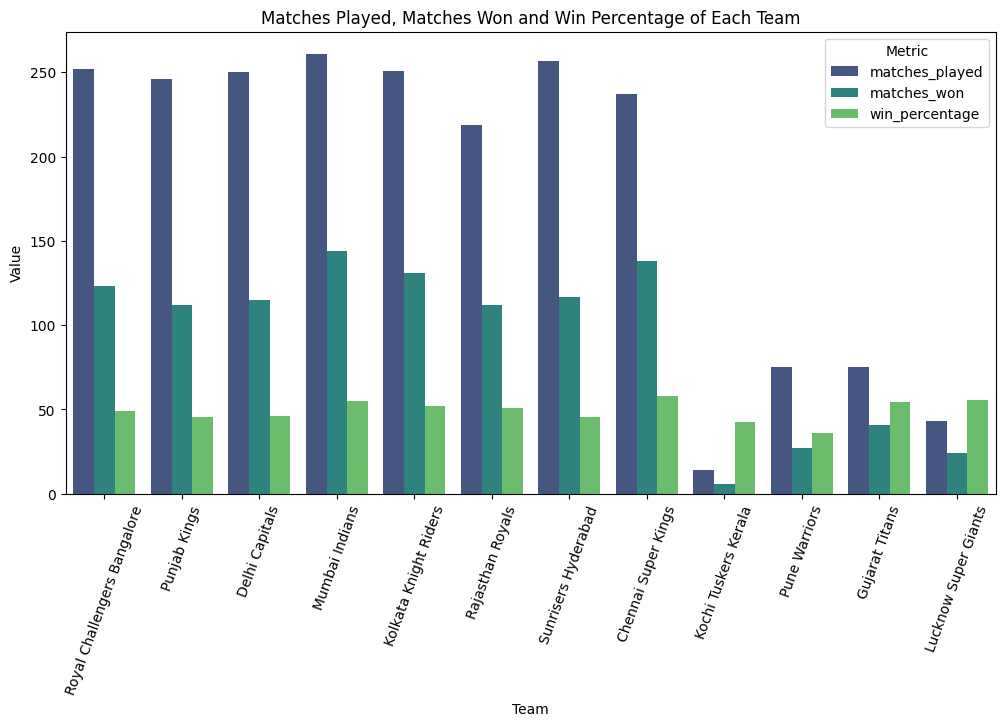

In [46]:
# Plotting Matches Played & Winning Percentage
team_stats_melted = team_stats.melt(id_vars=['team_name'], value_vars=['matches_played', 'matches_won', 'win_percentage'], 
                                    var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='team_name', y='Value', hue='Metric', data=team_stats_melted, palette='viridis')
plt.title('Matches Played, Matches Won and Win Percentage of Each Team')
plt.xlabel('Team')
plt.ylabel('Value')
plt.xticks(rotation=70)
plt.legend(title='Metric')
plt.show()

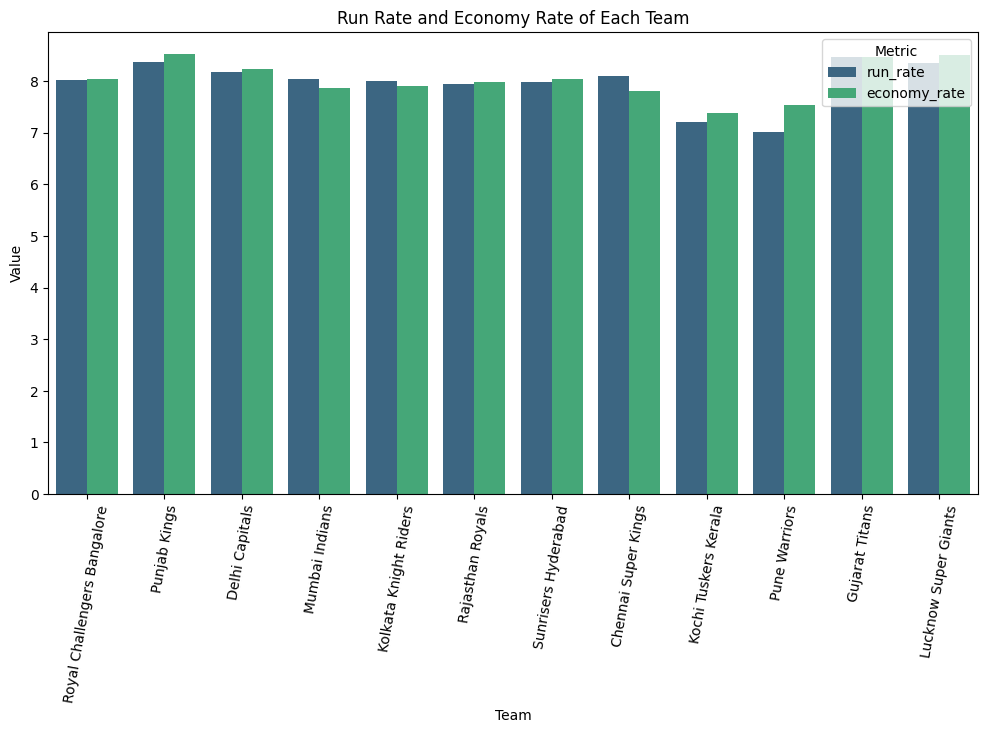

In [47]:
# Plotting Run Rate & Economy Rate
team_stats_melted = team_stats.melt(id_vars=['team_name'], value_vars=['run_rate', 'economy_rate'], 
                                    var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='team_name', y='Value', hue='Metric', data=team_stats_melted, palette='viridis')
plt.title('Run Rate and Economy Rate of Each Team')
plt.xlabel('Team')
plt.ylabel('Value')
plt.xticks(rotation=80)
plt.legend(title='Metric')
plt.show()

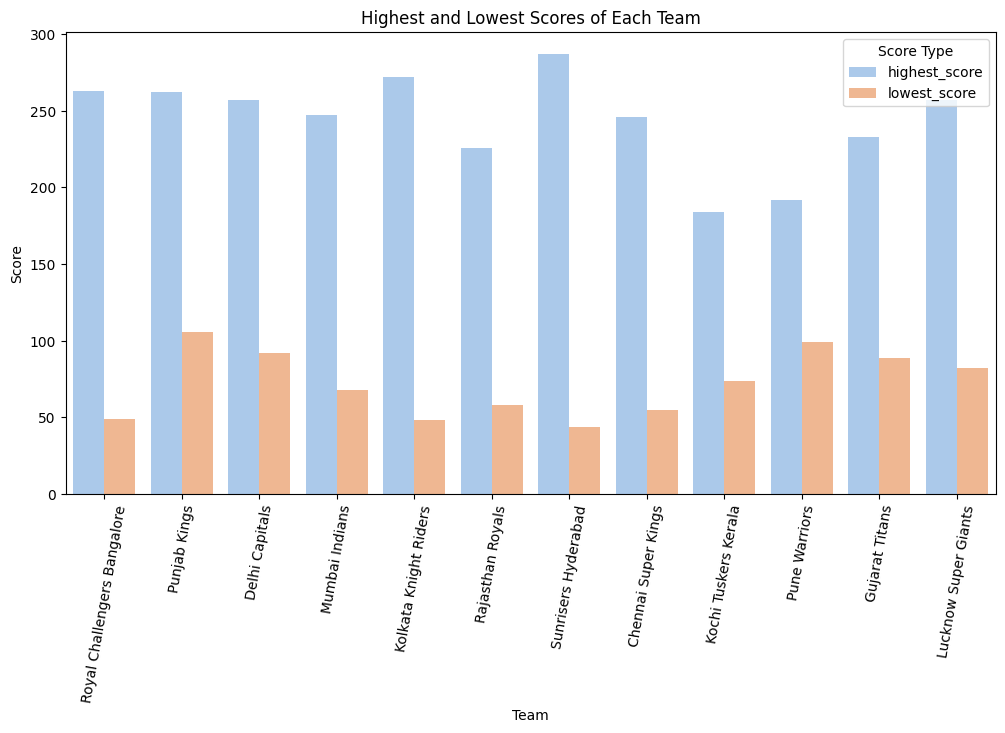

In [48]:
# Plotting Highest and Lowest Scores
plt.figure(figsize=(12, 6))
team_stats_melted = team_stats.melt(id_vars=['team_name'], value_vars=['highest_score', 'lowest_score'], 
                                    var_name='Score Type', value_name='Score')

sns.barplot(x='team_name', y='Score', hue='Score Type', data=team_stats_melted, palette='pastel')
plt.title('Highest and Lowest Scores of Each Team')
plt.xlabel('Team')
plt.ylabel('Score')
plt.xticks(rotation=80)
plt.show()

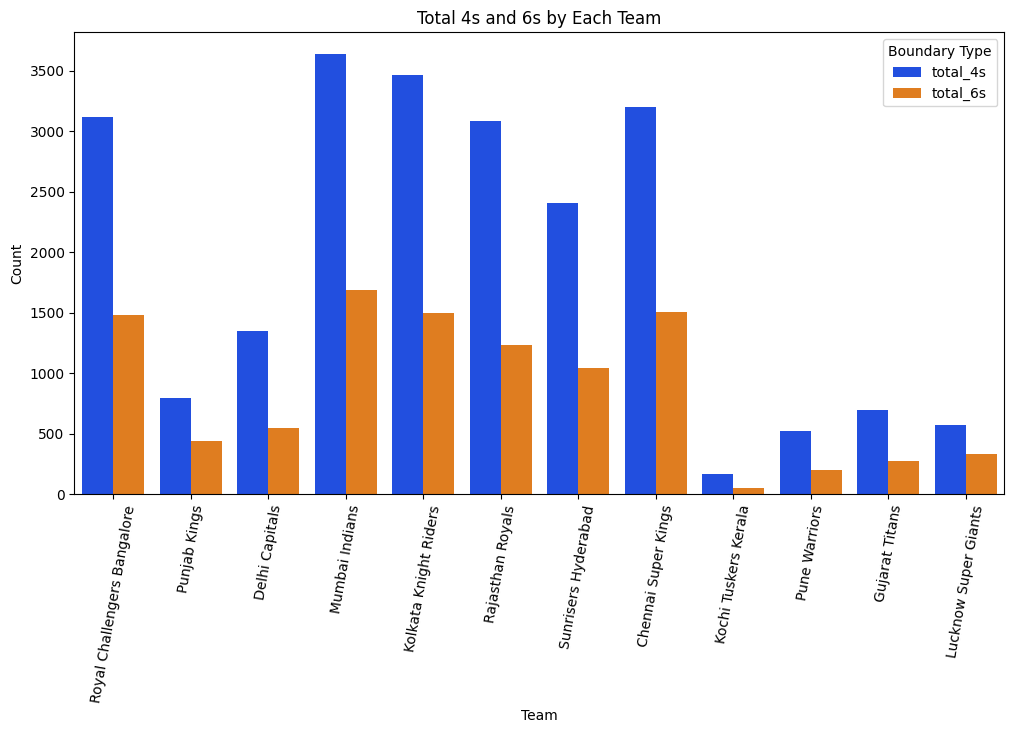

In [49]:
# Plotting Total 4s and 6s
plt.figure(figsize=(12, 6))
team_stats_melted = team_stats.melt(id_vars=['team_name'], value_vars=['total_4s', 'total_6s'], 
                                    var_name='Boundary Type', value_name='Count')
sns.barplot(x='team_name', y='Count', hue='Boundary Type', data=team_stats_melted, palette='bright')
plt.title('Total 4s and 6s by Each Team')
plt.xlabel('Team')
plt.ylabel('Count')
plt.xticks(rotation=80)
plt.show()

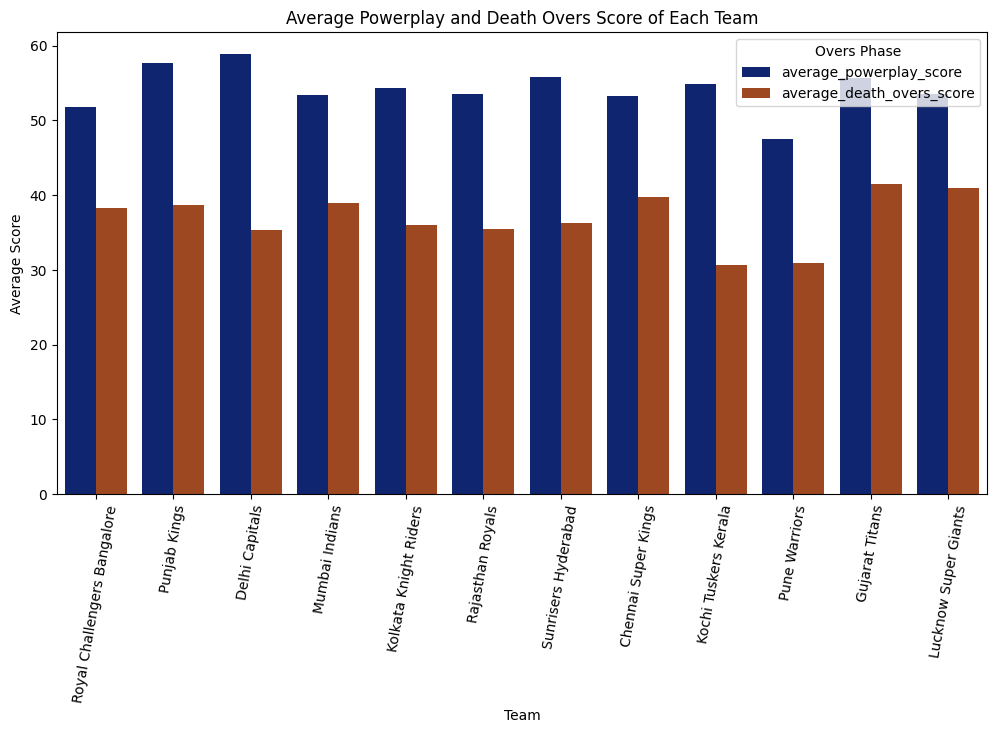

In [50]:
# Plotting Average Powerplay and Death Overs Score
plt.figure(figsize=(12, 6))
team_stats_melted = team_stats.melt(id_vars=['team_name'], value_vars=['average_powerplay_score', 'average_death_overs_score'], 
                                    var_name='Overs Phase', value_name='Average Score')
sns.barplot(x='team_name', y='Average Score', hue='Overs Phase', data=team_stats_melted, palette='dark')
plt.title('Average Powerplay and Death Overs Score of Each Team')
plt.xlabel('Team')
plt.ylabel('Average Score')
plt.xticks(rotation=80)
plt.show()

## 2. Player Performance

In [51]:
players.head()

matches  balls_faced  innings   runs     0s     1s    2s   3s  \
A Ashish Reddy     28.0        196.0      2.0  280.0   61.0   83.0  20.0  1.0   
A Badoni           35.0        505.0      2.0  634.0  183.0  201.0  48.0  3.0   
A Chandila         12.0          7.0      1.0    4.0    3.0    4.0   0.0  0.0   
A Chopra            6.0         75.0      2.0   53.0   45.0   21.0   2.0  0.0   
A Choudhary         5.0         20.0      2.0   25.0    4.0   13.0   1.0  0.0   

                  4s    6s  ...  batting_avg  batting_strike_rate  \
A Ashish Reddy  16.0  15.0  ...        18.67               142.86   
A Badoni        46.0  24.0  ...        24.38               125.54   
A Chandila       0.0   0.0  ...         4.00                57.14   
A Chopra         7.0   0.0  ...        10.60                70.67   
A Choudhary      1.0   1.0  ...        12.50               125.00   

                balls_throw  wickets  overs  runs_conceded  bowling_econ  \
A Ashish Reddy        270.0     18.0   45.0          396.0          8.80   
A Badoni               25.0      2.0    4.0           36.0          9.00   
A Chandila            234.0     11.0   39.0          242.0          6.21   
A Chopra                0.0      0.0    0.0            0.0          0.00   
A Choudhary           108.0      5.0   18.0          144.0          8.00   

                bowling_strike_rate  catches  man_of_the_match_count  
A Ashish Reddy                15.00      9.0                     0.0  
A Badoni                      12.50     14.0                     0.0  
A Chandila                    21.27      7.0                     1.0  
A Chopra                       0.00      2.0                     0.0  
A Choudhary                   21.60      0.0                     0.0  

[5 rows x 22 columns]

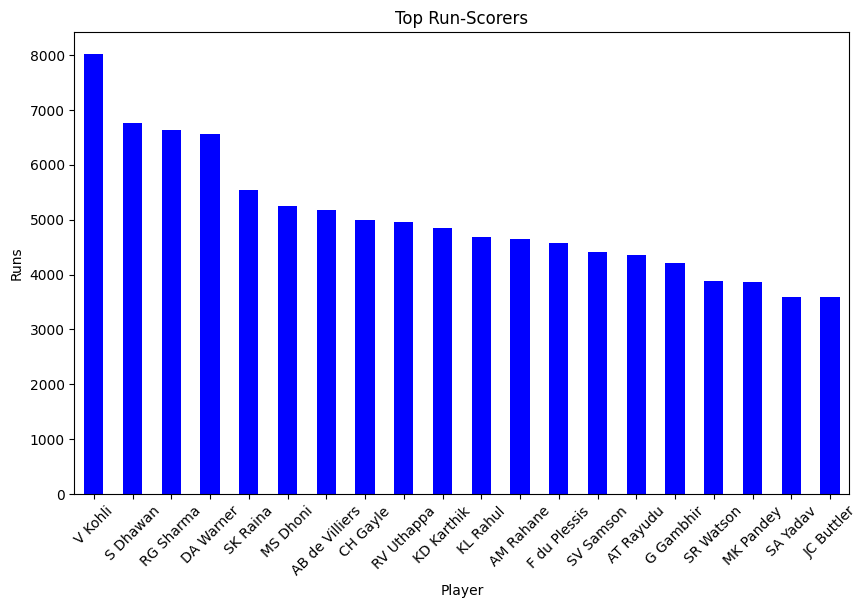

In [52]:
# Plotting top run-scorers
plt.figure(figsize=(10, 6))
top_run_scorers = players['runs'].nlargest(20)
top_run_scorers.plot(kind='bar', color='blue')
plt.xlabel('Player')
plt.ylabel('Runs')
plt.title('Top Run-Scorers')
plt.xticks(rotation=45)
plt.show()

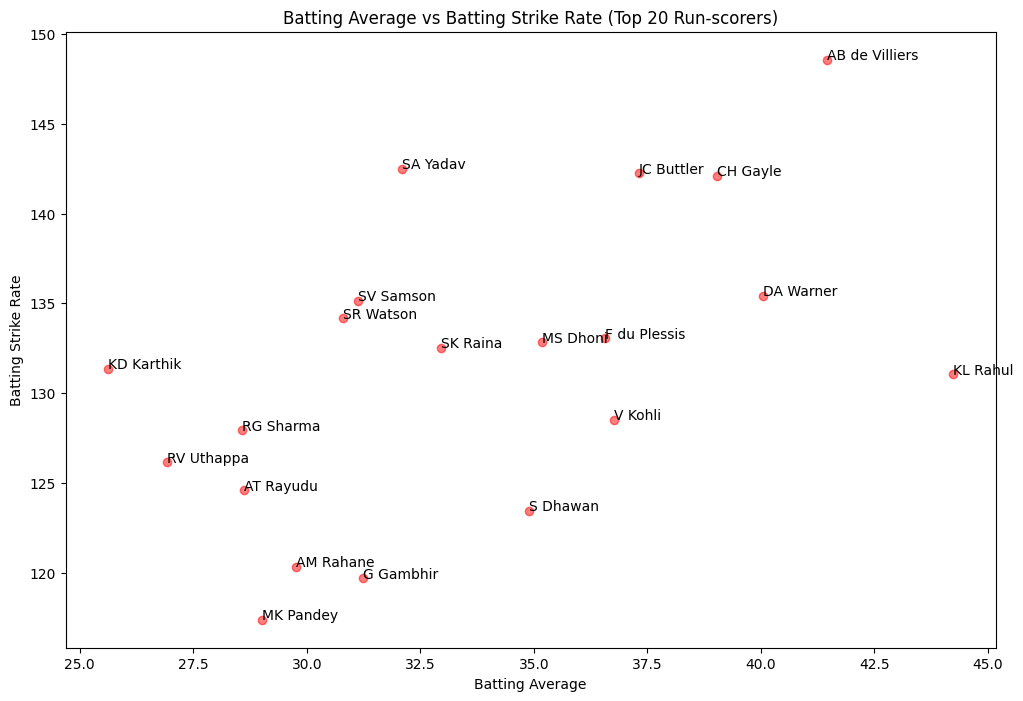

In [53]:
# Get the top 20 run-scorers
top_run_scorers = players.nlargest(20, 'runs')

# Plotting Batting Average vs Batting Strike Rate for the top 20 run-scorers
plt.figure(figsize=(12, 8))
plt.scatter(top_run_scorers['batting_avg'], top_run_scorers['batting_strike_rate'], color='red', alpha=0.5)
plt.xlabel('Batting Average')
plt.ylabel('Batting Strike Rate')
plt.title('Batting Average vs Batting Strike Rate (Top 20 Run-scorers)')

# Annotate each point with the player name
for i, player in top_run_scorers.iterrows():
    plt.annotate(i, (player['batting_avg'], player['batting_strike_rate']))

plt.show()

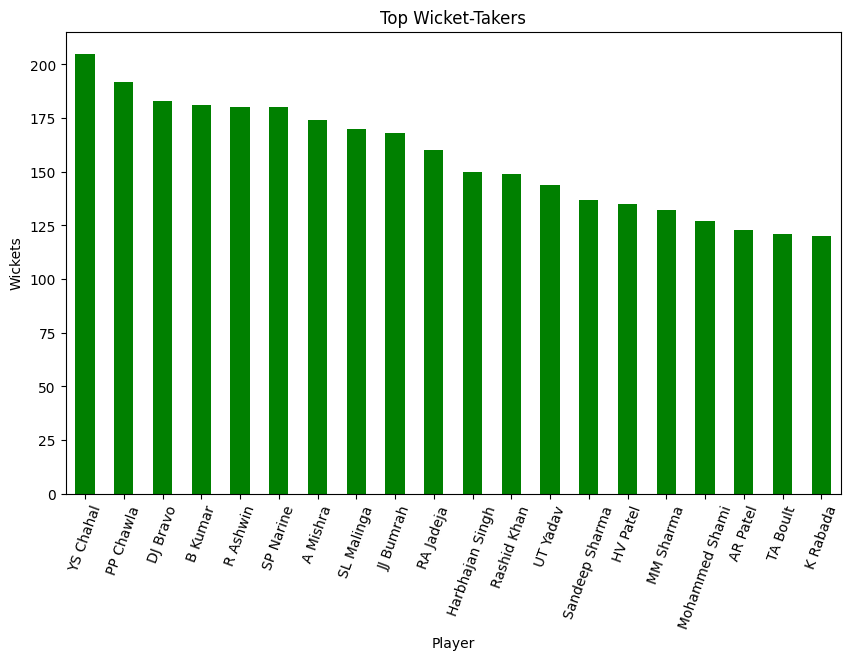

In [54]:
# Plotting top wicket-takers
plt.figure(figsize=(10, 6))
top_wicket_takers = players['wickets'].nlargest(20)
top_wicket_takers.plot(kind='bar', color='green')
plt.xlabel('Player')
plt.ylabel('Wickets')
plt.title('Top Wicket-Takers')
plt.xticks(rotation=70)
plt.show()

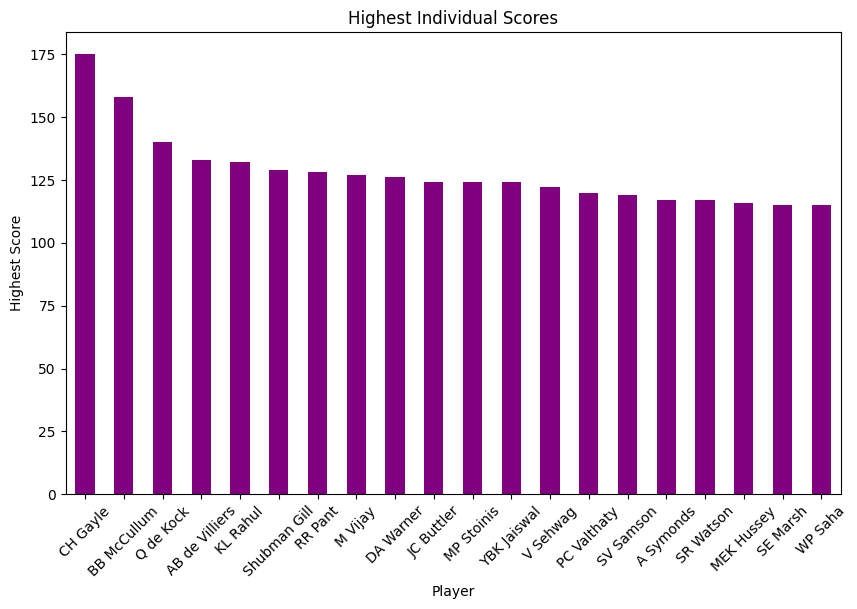

In [55]:
# Plotting top highest individual scores
plt.figure(figsize=(10, 6))
highest_scores = players['highest_score'].nlargest(20)
highest_scores.plot(kind='bar', color='purple')
plt.xlabel('Player')
plt.ylabel('Highest Score')
plt.title('Highest Individual Scores')
plt.xticks(rotation=45)
plt.show()

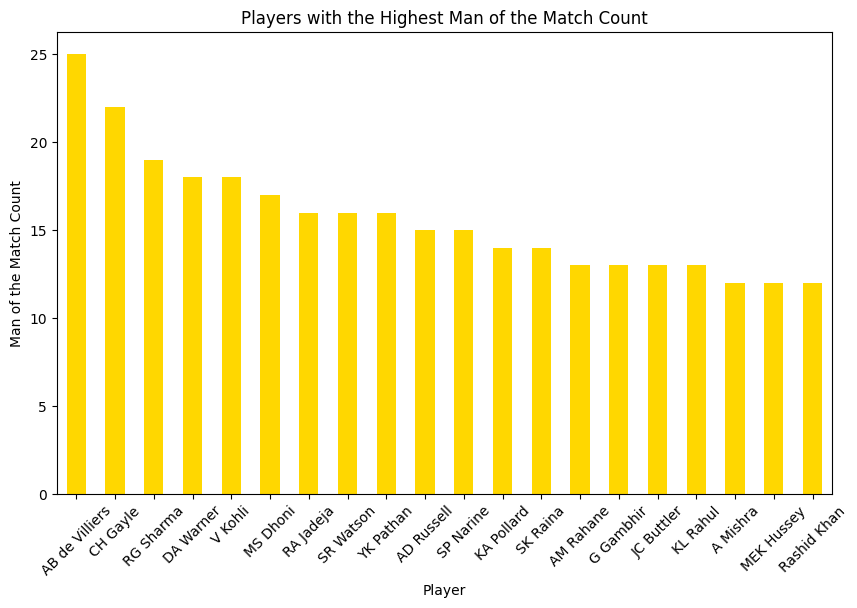

In [56]:
# Man of the Match Count
plt.figure(figsize=(10, 6))
top_mom_players = players['man_of_the_match_count'].nlargest(20)
top_mom_players.plot(kind='bar', color='gold')
plt.xlabel('Player')
plt.ylabel('Man of the Match Count')
plt.title('Players with the Highest Man of the Match Count')
plt.xticks(rotation=45)
plt.show()

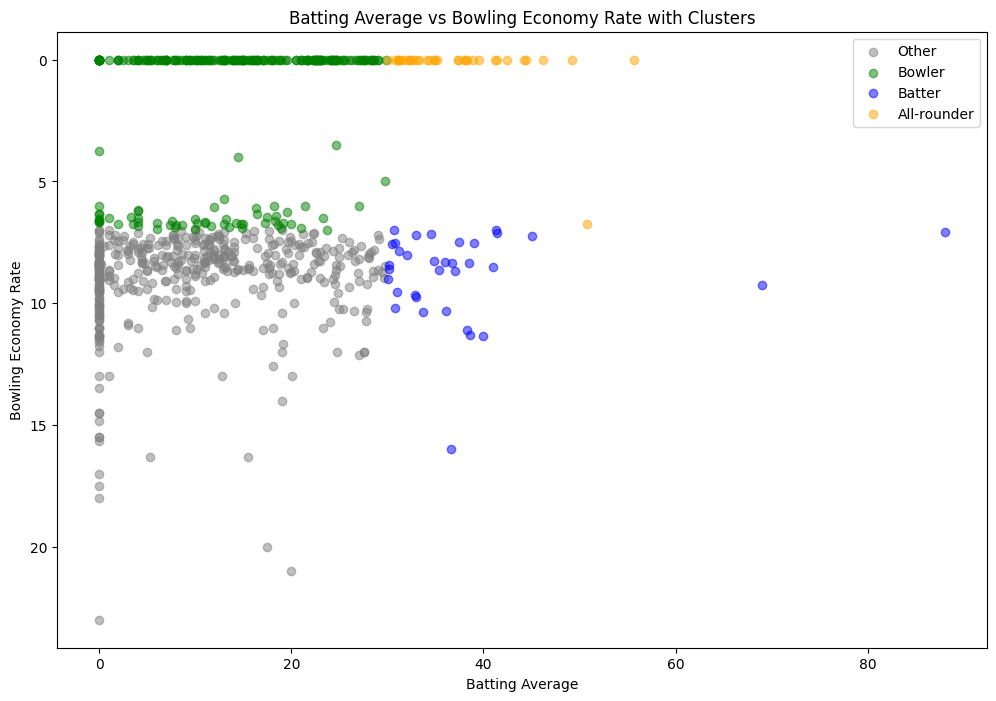

In [57]:
# Define thresholds for clustering
batting_avg_threshold = 30
bowling_econ_threshold = 7

# Identify clusters
players['cluster'] = 'Other'
players.loc[players['batting_avg'] > batting_avg_threshold, 'cluster'] = 'Batter'
players.loc[players['bowling_econ'] < bowling_econ_threshold, 'cluster'] = 'Bowler'
players.loc[(players['batting_avg'] > batting_avg_threshold) & (players['bowling_econ'] < bowling_econ_threshold), 'cluster'] = 'All-rounder'

# Plotting Batting Average vs Bowling Economy Rate with clusters
plt.figure(figsize=(12, 8))
colors = {'Batter': 'blue', 'Bowler': 'green', 'All-rounder': 'orange', 'Other': 'grey'}

for cluster in players['cluster'].unique():
    subset = players[players['cluster'] == cluster]
    plt.scatter(subset['batting_avg'], subset['bowling_econ'], 
                color=colors[cluster], label=cluster, alpha=0.5)

plt.xlabel('Batting Average')
plt.ylabel('Bowling Economy Rate')
plt.title('Batting Average vs Bowling Economy Rate with Clusters')
plt.gca().invert_yaxis()  # Invert y-axis to show better economy rates higher up
plt.legend()
plt.show()

## 3. Seasonal Analysis

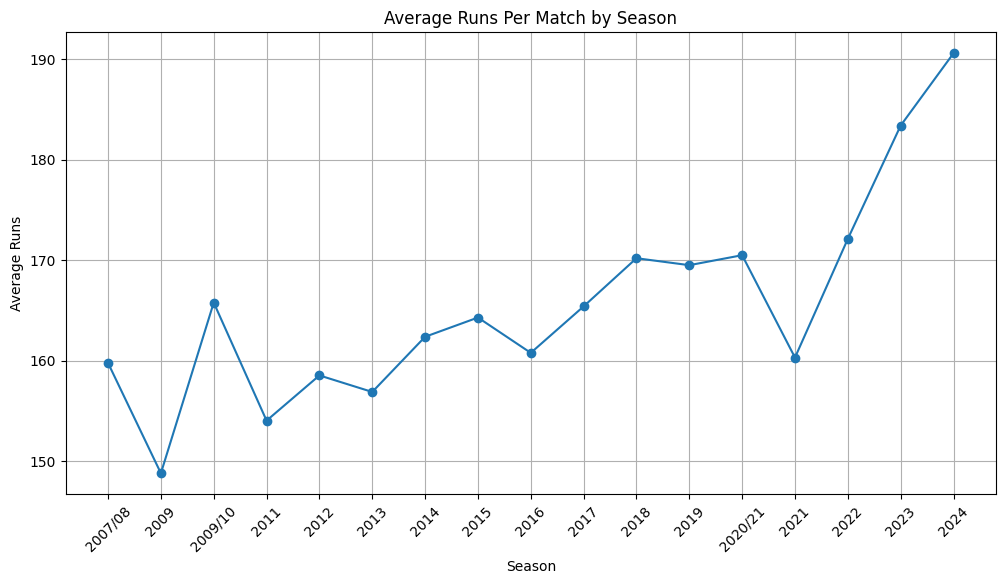

In [58]:
# Calculate average runs per match per season
seasonal_runs = matches.groupby('season').agg({'target_runs': 'mean'}).reset_index()
seasonal_runs.columns = ['season', 'average_runs']

plt.figure(figsize=(12, 6))
plt.plot(seasonal_runs['season'], seasonal_runs['average_runs'], marker='o')
plt.title('Average Runs Per Match by Season')
plt.xlabel('Season')
plt.ylabel('Average Runs')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# **Winner Prediction Model**

In [59]:
deliveries = deliveries_df.copy()
matches = matches_df.copy()

In [60]:
inning_scores = deliveries.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()
inning_scores = inning_scores[inning_scores['inning']==1]
inning_scores.head()

match_id  inning  total_runs
0    335982       1         222
2    335983       1         240
4    335984       1         129
6    335985       1         165
8    335986       1         110

In [61]:
inning_scores['target'] = inning_scores['total_runs'] + 1
inning_scores.head()

match_id  inning  total_runs  target
0    335982       1         222     223
2    335983       1         240     241
4    335984       1         129     130
6    335985       1         165     166
8    335986       1         110     111

In [62]:
matches.rename(columns={'id': 'match_id'}, inplace=True)
matches.head()

match_id   season        city        date match_type player_of_match  \
0    335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1    335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2    335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3    335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4    335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner toss_decision  \
0        Kolkata Knight Riders  Royal Challengers Bangalore         field   
1          Chennai Super Kings          Chennai Super Kings           bat   
2             Rajasthan Royals             Rajasthan Royals           bat   
3  Royal Challengers Bangalore               Mumbai Indians           bat   
4              Deccan Chargers              Deccan Chargers           bat   

                        winner   result  result_margin  target_runs  \
0        Kolkata Knight Riders     runs          140.0        223.0   
1          Chennai Super Kings     runs           33.0        241.0   
2             Delhi Daredevils  wickets            9.0        130.0   
3  Royal Challengers Bangalore  wickets            5.0        166.0   
4        Kolkata Knight Riders  wickets            5.0        111.0   

   target_overs super_over method    umpire1         umpire2  
0          20.0          N    NaN  Asad Rauf     RE Koertzen  
1          20.0          N    NaN  MR Benson      SL Shastri  
2          20.0          N    NaN  Aleem Dar  GA Pratapkumar  
3          20.0          N    NaN   SJ Davis       DJ Harper  
4          20.0          N    NaN  BF Bowden     K Hariharan

In [63]:
matches = matches.merge(inning_scores[['match_id','target']], on='match_id')
matches.head()

match_id   season        city        date match_type player_of_match  \
0    335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1    335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2    335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3    335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4    335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali              Kings XI Punjab   
2                            Feroz Shah Kotla             Delhi Daredevils   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner  ...  \
0        Kolkata Knight Riders  Royal Challengers Bangalore  ...   
1          Chennai Super Kings          Chennai Super Kings  ...   
2             Rajasthan Royals             Rajasthan Royals  ...   
3  Royal Challengers Bangalore               Mumbai Indians  ...   
4              Deccan Chargers              Deccan Chargers  ...   

                        winner   result result_margin  target_runs  \
0        Kolkata Knight Riders     runs         140.0        223.0   
1          Chennai Super Kings     runs          33.0        241.0   
2             Delhi Daredevils  wickets           9.0        130.0   
3  Royal Challengers Bangalore  wickets           5.0        166.0   
4        Kolkata Knight Riders  wickets           5.0        111.0   

   target_overs  super_over method    umpire1         umpire2 target  
0          20.0           N    NaN  Asad Rauf     RE Koertzen    223  
1          20.0           N    NaN  MR Benson      SL Shastri    241  
2          20.0           N    NaN  Aleem Dar  GA Pratapkumar    130  
3          20.0           N    NaN   SJ Davis       DJ Harper    166  
4          20.0           N    NaN  BF Bowden     K Hariharan    111  

[5 rows x 21 columns]

In [64]:
matches['team1'].unique()

array(['Royal Challengers Bangalore', 'Kings XI Punjab',
       'Delhi Daredevils', 'Mumbai Indians', 'Kolkata Knight Riders',
       'Rajasthan Royals', 'Deccan Chargers', 'Chennai Super Kings',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Sunrisers Hyderabad',
       'Gujarat Lions', 'Rising Pune Supergiants',
       'Rising Pune Supergiant', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru'], dtype=object)

In [65]:
# Mapping dictionary for old names to standardized names
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Kings XI Punjab': 'Punjab Kings',
    'Rising Pune Supergiants': 'Pune Warriors',
    'Rising Pune Supergiant': 'Pune Warriors',
    'Gujarat Lions': 'Gujarat Titans',
    'Deccan Chargers': 'Sunrisers Hyderabad',
    'Royal Challengers Bengaluru': 'Royal Challengers Bangalore',
}

team_columns = ['winner', 'team1', 'team2', 'toss_winner']

# Replace the team names in team columns
matches[team_columns] = matches[team_columns].replace(team_name_mapping)

In [66]:
# Teams that will play in 2025 season
teams_2025 = [
    'Chennai Super Kings',
    'Delhi Capitals',
    'Gujarat Titans',
    'Kolkata Knight Riders',
    'Lucknow Super Giants',
    'Mumbai Indians',
    'Punjab Kings',
    'Rajasthan Royals',
    'Royal Challengers Bangalore',
    'Sunrisers Hyderabad', 
]

# Extracting only the selected teams
matches = matches[matches['team1'].isin(teams_2025)]
matches = matches[matches['team2'].isin(teams_2025)]

matches.head()

match_id   season        city        date match_type player_of_match  \
0    335982  2007/08   Bangalore  2008-04-18     League     BB McCullum   
1    335983  2007/08  Chandigarh  2008-04-19     League      MEK Hussey   
2    335984  2007/08       Delhi  2008-04-19     League     MF Maharoof   
3    335985  2007/08      Mumbai  2008-04-20     League      MV Boucher   
4    335986  2007/08     Kolkata  2008-04-20     League       DJ Hussey   

                                        venue                        team1  \
0                       M Chinnaswamy Stadium  Royal Challengers Bangalore   
1  Punjab Cricket Association Stadium, Mohali                 Punjab Kings   
2                            Feroz Shah Kotla               Delhi Capitals   
3                            Wankhede Stadium               Mumbai Indians   
4                                Eden Gardens        Kolkata Knight Riders   

                         team2                  toss_winner  ...  \
0        Kolkata Knight Riders  Royal Challengers Bangalore  ...   
1          Chennai Super Kings          Chennai Super Kings  ...   
2             Rajasthan Royals             Rajasthan Royals  ...   
3  Royal Challengers Bangalore               Mumbai Indians  ...   
4          Sunrisers Hyderabad          Sunrisers Hyderabad  ...   

                        winner   result result_margin  target_runs  \
0        Kolkata Knight Riders     runs         140.0        223.0   
1          Chennai Super Kings     runs          33.0        241.0   
2               Delhi Capitals  wickets           9.0        130.0   
3  Royal Challengers Bangalore  wickets           5.0        166.0   
4        Kolkata Knight Riders  wickets           5.0        111.0   

   target_overs  super_over method    umpire1         umpire2 target  
0          20.0           N    NaN  Asad Rauf     RE Koertzen    223  
1          20.0           N    NaN  MR Benson      SL Shastri    241  
2          20.0           N    NaN  Aleem Dar  GA Pratapkumar    130  
3          20.0           N    NaN   SJ Davis       DJ Harper    166  
4          20.0           N    NaN  BF Bowden     K Hariharan    111  

[5 rows x 21 columns]

In [67]:
matches['city'].unique()

array(['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi', nan,
       'Rajkot', 'Kanpur', 'Bengaluru', 'Indore', 'Dubai', 'Sharjah',
       'Navi Mumbai', 'Lucknow', 'Guwahati', 'Mohali'], dtype=object)

In [68]:
# Rplace city names
map_city_names = {'Bengaluru': 'Bangalore'}
matches['city'] = matches['city'].replace(map_city_names)

matches['city'].unique()

array(['Bangalore', 'Chandigarh', 'Delhi', 'Mumbai', 'Kolkata', 'Jaipur',
       'Hyderabad', 'Chennai', 'Cape Town', 'Port Elizabeth', 'Durban',
       'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi', nan,
       'Rajkot', 'Kanpur', 'Indore', 'Dubai', 'Sharjah', 'Navi Mumbai',
       'Lucknow', 'Guwahati', 'Mohali'], dtype=object)

In [69]:
matches.isnull().sum()

match_id             0
season               0
city                51
date                 0
match_type           0
player_of_match      4
venue                0
team1                0
team2                0
toss_winner          0
toss_decision        0
winner               4
result               0
result_margin       18
target_runs          2
target_overs         2
super_over           0
method             989
umpire1              0
umpire2              0
target               0
dtype: int64

In [70]:
# Extracting only selected columns
matches = matches[['match_id', 'season', 'city', 'team1', 'team2', 'winner', 'target']].dropna()
matches.head()

match_id   season        city                        team1  \
0    335982  2007/08   Bangalore  Royal Challengers Bangalore   
1    335983  2007/08  Chandigarh                 Punjab Kings   
2    335984  2007/08       Delhi               Delhi Capitals   
3    335985  2007/08      Mumbai               Mumbai Indians   
4    335986  2007/08     Kolkata        Kolkata Knight Riders   

                         team2                       winner  target  
0        Kolkata Knight Riders        Kolkata Knight Riders     223  
1          Chennai Super Kings          Chennai Super Kings     241  
2             Rajasthan Royals               Delhi Capitals     130  
3  Royal Challengers Bangalore  Royal Challengers Bangalore     166  
4          Sunrisers Hyderabad        Kolkata Knight Riders     111

In [71]:
matches.isnull().sum()

match_id    0
season      0
city        0
team1       0
team2       0
winner      0
target      0
dtype: int64

In [72]:
# Replace the team names in the 'batting_team' column
deliveries['batting_team'] = deliveries['batting_team'].replace(team_name_mapping)
deliveries['bowling_team'] = deliveries['bowling_team'].replace(team_name_mapping)

deliveries = deliveries[deliveries['batting_team'].isin(teams_2025)]
deliveries = deliveries[deliveries['bowling_team'].isin(teams_2025)]
deliveries.head()

match_id  inning           batting_team                 bowling_team  over  \
0    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
1    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
2    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
3    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   
4    335982       1  Kolkata Knight Riders  Royal Challengers Bangalore     0   

   ball       batter   bowler  non_striker  batsman_runs  extra_runs  \
0     1   SC Ganguly  P Kumar  BB McCullum             0           1   
1     2  BB McCullum  P Kumar   SC Ganguly             0           0   
2     3  BB McCullum  P Kumar   SC Ganguly             0           1   
3     4  BB McCullum  P Kumar   SC Ganguly             0           0   
4     5  BB McCullum  P Kumar   SC Ganguly             0           0   

   total_runs extras_type  is_wicket player_dismissed dismissal_kind fielder  
0           1     legbyes          0              NaN            NaN     NaN  
1           0         NaN          0              NaN            NaN     NaN  
2           1       wides          0              NaN            NaN     NaN  
3           0         NaN          0              NaN            NaN     NaN  
4           0         NaN          0              NaN            NaN     NaN

In [73]:
# Merge to the final dataset
final = matches.merge(deliveries, on='match_id')
final.head()

match_id   season       city                        team1  \
0    335982  2007/08  Bangalore  Royal Challengers Bangalore   
1    335982  2007/08  Bangalore  Royal Challengers Bangalore   
2    335982  2007/08  Bangalore  Royal Challengers Bangalore   
3    335982  2007/08  Bangalore  Royal Challengers Bangalore   
4    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                   team2                 winner  target  inning  \
0  Kolkata Knight Riders  Kolkata Knight Riders     223       1   
1  Kolkata Knight Riders  Kolkata Knight Riders     223       1   
2  Kolkata Knight Riders  Kolkata Knight Riders     223       1   
3  Kolkata Knight Riders  Kolkata Knight Riders     223       1   
4  Kolkata Knight Riders  Kolkata Knight Riders     223       1   

            batting_team                 bowling_team  ...   bowler  \
0  Kolkata Knight Riders  Royal Challengers Bangalore  ...  P Kumar   
1  Kolkata Knight Riders  Royal Challengers Bangalore  ...  P Kumar   
2  Kolkata Knight Riders  Royal Challengers Bangalore  ...  P Kumar   
3  Kolkata Knight Riders  Royal Challengers Bangalore  ...  P Kumar   
4  Kolkata Knight Riders  Royal Challengers Bangalore  ...  P Kumar   

   non_striker batsman_runs extra_runs total_runs  extras_type  is_wicket  \
0  BB McCullum            0          1          1      legbyes          0   
1   SC Ganguly            0          0          0          NaN          0   
2   SC Ganguly            0          1          1        wides          0   
3   SC Ganguly            0          0          0          NaN          0   
4   SC Ganguly            0          0          0          NaN          0   

   player_dismissed dismissal_kind  fielder  
0               NaN            NaN      NaN  
1               NaN            NaN      NaN  
2               NaN            NaN      NaN  
3               NaN            NaN      NaN  
4               NaN            NaN      NaN  

[5 rows x 23 columns]

In [74]:
# Get only second inning matches
final = final[final['inning'] == 2]
final.head()

match_id   season       city                        team1  \
124    335982  2007/08  Bangalore  Royal Challengers Bangalore   
125    335982  2007/08  Bangalore  Royal Challengers Bangalore   
126    335982  2007/08  Bangalore  Royal Challengers Bangalore   
127    335982  2007/08  Bangalore  Royal Challengers Bangalore   
128    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                     team2                 winner  target  inning  \
124  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
125  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
126  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
127  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
128  Kolkata Knight Riders  Kolkata Knight Riders     223       2   

                    batting_team           bowling_team  ...    bowler  \
124  Royal Challengers Bangalore  Kolkata Knight Riders  ...  AB Dinda   
125  Royal Challengers Bangalore  Kolkata Knight Riders  ...  AB Dinda   
126  Royal Challengers Bangalore  Kolkata Knight Riders  ...  AB Dinda   
127  Royal Challengers Bangalore  Kolkata Knight Riders  ...  AB Dinda   
128  Royal Challengers Bangalore  Kolkata Knight Riders  ...  AB Dinda   

     non_striker batsman_runs extra_runs total_runs  extras_type  is_wicket  \
124     W Jaffer            1          0          1          NaN          0   
125     R Dravid            0          1          1        wides          0   
126     R Dravid            0          0          0          NaN          0   
127     R Dravid            1          0          1          NaN          0   
128     W Jaffer            1          0          1          NaN          0   

     player_dismissed dismissal_kind  fielder  
124               NaN            NaN      NaN  
125               NaN            NaN      NaN  
126               NaN            NaN      NaN  
127               NaN            NaN      NaN  
128               NaN            NaN      NaN  

[5 rows x 23 columns]

In [75]:
# Add 'current_score'
final.loc[:, 'current_score'] = final.groupby('match_id')['total_runs'].cumsum()
final.head()

match_id   season       city                        team1  \
124    335982  2007/08  Bangalore  Royal Challengers Bangalore   
125    335982  2007/08  Bangalore  Royal Challengers Bangalore   
126    335982  2007/08  Bangalore  Royal Challengers Bangalore   
127    335982  2007/08  Bangalore  Royal Challengers Bangalore   
128    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                     team2                 winner  target  inning  \
124  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
125  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
126  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
127  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
128  Kolkata Knight Riders  Kolkata Knight Riders     223       2   

                    batting_team           bowling_team  ...  non_striker  \
124  Royal Challengers Bangalore  Kolkata Knight Riders  ...     W Jaffer   
125  Royal Challengers Bangalore  Kolkata Knight Riders  ...     R Dravid   
126  Royal Challengers Bangalore  Kolkata Knight Riders  ...     R Dravid   
127  Royal Challengers Bangalore  Kolkata Knight Riders  ...     R Dravid   
128  Royal Challengers Bangalore  Kolkata Knight Riders  ...     W Jaffer   

     batsman_runs extra_runs total_runs extras_type  is_wicket  \
124             1          0          1         NaN          0   
125             0          1          1       wides          0   
126             0          0          0         NaN          0   
127             1          0          1         NaN          0   
128             1          0          1         NaN          0   

     player_dismissed  dismissal_kind fielder  current_score  
124               NaN             NaN     NaN              1  
125               NaN             NaN     NaN              2  
126               NaN             NaN     NaN              2  
127               NaN             NaN     NaN              3  
128               NaN             NaN     NaN              4  

[5 rows x 24 columns]

In [76]:
# Add 'runs_left'
final.loc[:, 'runs_left'] = np.where(final['target']-final['current_score']>=0, final['target']-final['current_score'], 0)
final.head()

match_id   season       city                        team1  \
124    335982  2007/08  Bangalore  Royal Challengers Bangalore   
125    335982  2007/08  Bangalore  Royal Challengers Bangalore   
126    335982  2007/08  Bangalore  Royal Challengers Bangalore   
127    335982  2007/08  Bangalore  Royal Challengers Bangalore   
128    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                     team2                 winner  target  inning  \
124  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
125  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
126  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
127  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
128  Kolkata Knight Riders  Kolkata Knight Riders     223       2   

                    batting_team           bowling_team  ...  batsman_runs  \
124  Royal Challengers Bangalore  Kolkata Knight Riders  ...             1   
125  Royal Challengers Bangalore  Kolkata Knight Riders  ...             0   
126  Royal Challengers Bangalore  Kolkata Knight Riders  ...             0   
127  Royal Challengers Bangalore  Kolkata Knight Riders  ...             1   
128  Royal Challengers Bangalore  Kolkata Knight Riders  ...             1   

     extra_runs total_runs extras_type is_wicket  player_dismissed  \
124           0          1         NaN         0               NaN   
125           1          1       wides         0               NaN   
126           0          0         NaN         0               NaN   
127           0          1         NaN         0               NaN   
128           0          1         NaN         0               NaN   

     dismissal_kind  fielder current_score  runs_left  
124             NaN      NaN             1        222  
125             NaN      NaN             2        221  
126             NaN      NaN             2        221  
127             NaN      NaN             3        220  
128             NaN      NaN             4        219  

[5 rows x 25 columns]

In [77]:
# Add 'balls_left'
final.loc[:, 'balls_left'] = np.where(120 - final['over']*6 - final['ball']>=0, 120 - final['over']*6 - final['ball'], 0)
final.head()

match_id   season       city                        team1  \
124    335982  2007/08  Bangalore  Royal Challengers Bangalore   
125    335982  2007/08  Bangalore  Royal Challengers Bangalore   
126    335982  2007/08  Bangalore  Royal Challengers Bangalore   
127    335982  2007/08  Bangalore  Royal Challengers Bangalore   
128    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                     team2                 winner  target  inning  \
124  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
125  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
126  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
127  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
128  Kolkata Knight Riders  Kolkata Knight Riders     223       2   

                    batting_team           bowling_team  ...  extra_runs  \
124  Royal Challengers Bangalore  Kolkata Knight Riders  ...           0   
125  Royal Challengers Bangalore  Kolkata Knight Riders  ...           1   
126  Royal Challengers Bangalore  Kolkata Knight Riders  ...           0   
127  Royal Challengers Bangalore  Kolkata Knight Riders  ...           0   
128  Royal Challengers Bangalore  Kolkata Knight Riders  ...           0   

     total_runs extras_type is_wicket player_dismissed  dismissal_kind  \
124           1         NaN         0              NaN             NaN   
125           1       wides         0              NaN             NaN   
126           0         NaN         0              NaN             NaN   
127           1         NaN         0              NaN             NaN   
128           1         NaN         0              NaN             NaN   

     fielder  current_score runs_left  balls_left  
124      NaN              1       222         119  
125      NaN              2       221         118  
126      NaN              2       221         117  
127      NaN              3       220         116  
128      NaN              4       219         115  

[5 rows x 26 columns]

In [78]:
# Add 'wickets_left'
final.loc[:, 'wickets_left'] = 10 - final.groupby('match_id')['is_wicket'].cumsum()
final.head()

match_id   season       city                        team1  \
124    335982  2007/08  Bangalore  Royal Challengers Bangalore   
125    335982  2007/08  Bangalore  Royal Challengers Bangalore   
126    335982  2007/08  Bangalore  Royal Challengers Bangalore   
127    335982  2007/08  Bangalore  Royal Challengers Bangalore   
128    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                     team2                 winner  target  inning  \
124  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
125  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
126  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
127  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
128  Kolkata Knight Riders  Kolkata Knight Riders     223       2   

                    batting_team           bowling_team  ...  total_runs  \
124  Royal Challengers Bangalore  Kolkata Knight Riders  ...           1   
125  Royal Challengers Bangalore  Kolkata Knight Riders  ...           1   
126  Royal Challengers Bangalore  Kolkata Knight Riders  ...           0   
127  Royal Challengers Bangalore  Kolkata Knight Riders  ...           1   
128  Royal Challengers Bangalore  Kolkata Knight Riders  ...           1   

     extras_type is_wicket player_dismissed dismissal_kind  fielder  \
124          NaN         0              NaN            NaN      NaN   
125        wides         0              NaN            NaN      NaN   
126          NaN         0              NaN            NaN      NaN   
127          NaN         0              NaN            NaN      NaN   
128          NaN         0              NaN            NaN      NaN   

     current_score  runs_left balls_left  wickets_left  
124              1        222        119            10  
125              2        221        118            10  
126              2        221        117            10  
127              3        220        116            10  
128              4        219        115            10  

[5 rows x 27 columns]

In [79]:
# Calculate 'current_run_rate'
final['current_run_rate'] = np.where(
    120 - final['balls_left'] > 0,
    (final['current_score'] * 6) / (120 - final['balls_left']),
    0
)

# Calculate 'required_run_rate'
final['required_run_rate'] = np.where(
    final['balls_left'] > 0, 
    (final['runs_left'] * 6) / final['balls_left'], 
    np.where(final['runs_left'] > 0, 1e6, 0)
)

final.head()

match_id   season       city                        team1  \
124    335982  2007/08  Bangalore  Royal Challengers Bangalore   
125    335982  2007/08  Bangalore  Royal Challengers Bangalore   
126    335982  2007/08  Bangalore  Royal Challengers Bangalore   
127    335982  2007/08  Bangalore  Royal Challengers Bangalore   
128    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                     team2                 winner  target  inning  \
124  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
125  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
126  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
127  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
128  Kolkata Knight Riders  Kolkata Knight Riders     223       2   

                    batting_team           bowling_team  ...  is_wicket  \
124  Royal Challengers Bangalore  Kolkata Knight Riders  ...          0   
125  Royal Challengers Bangalore  Kolkata Knight Riders  ...          0   
126  Royal Challengers Bangalore  Kolkata Knight Riders  ...          0   
127  Royal Challengers Bangalore  Kolkata Knight Riders  ...          0   
128  Royal Challengers Bangalore  Kolkata Knight Riders  ...          0   

     player_dismissed dismissal_kind fielder current_score  runs_left  \
124               NaN            NaN     NaN             1        222   
125               NaN            NaN     NaN             2        221   
126               NaN            NaN     NaN             2        221   
127               NaN            NaN     NaN             3        220   
128               NaN            NaN     NaN             4        219   

     balls_left  wickets_left current_run_rate  required_run_rate  
124         119            10              6.0          11.193277  
125         118            10              6.0          11.237288  
126         117            10              4.0          11.333333  
127         116            10              4.5          11.379310  
128         115            10              4.8          11.426087  

[5 rows x 29 columns]

In [80]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

final['result'] = final.apply(result, axis=1)
final.head()

match_id   season       city                        team1  \
124    335982  2007/08  Bangalore  Royal Challengers Bangalore   
125    335982  2007/08  Bangalore  Royal Challengers Bangalore   
126    335982  2007/08  Bangalore  Royal Challengers Bangalore   
127    335982  2007/08  Bangalore  Royal Challengers Bangalore   
128    335982  2007/08  Bangalore  Royal Challengers Bangalore   

                     team2                 winner  target  inning  \
124  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
125  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
126  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
127  Kolkata Knight Riders  Kolkata Knight Riders     223       2   
128  Kolkata Knight Riders  Kolkata Knight Riders     223       2   

                    batting_team           bowling_team  ...  \
124  Royal Challengers Bangalore  Kolkata Knight Riders  ...   
125  Royal Challengers Bangalore  Kolkata Knight Riders  ...   
126  Royal Challengers Bangalore  Kolkata Knight Riders  ...   
127  Royal Challengers Bangalore  Kolkata Knight Riders  ...   
128  Royal Challengers Bangalore  Kolkata Knight Riders  ...   

     player_dismissed  dismissal_kind fielder current_score runs_left  \
124               NaN             NaN     NaN             1       222   
125               NaN             NaN     NaN             2       221   
126               NaN             NaN     NaN             2       221   
127               NaN             NaN     NaN             3       220   
128               NaN             NaN     NaN             4       219   

     balls_left  wickets_left  current_run_rate required_run_rate  result  
124         119            10               6.0         11.193277       0  
125         118            10               6.0         11.237288       0  
126         117            10               4.0         11.333333       0  
127         116            10               4.5         11.379310       0  
128         115            10               4.8         11.426087       0  

[5 rows x 30 columns]

In [81]:
winning_pred = final[['season', 'batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'current_run_rate', 'required_run_rate', 'target', 'result']]
winning_pred.head()

season                 batting_team           bowling_team       city  \
124  2007/08  Royal Challengers Bangalore  Kolkata Knight Riders  Bangalore   
125  2007/08  Royal Challengers Bangalore  Kolkata Knight Riders  Bangalore   
126  2007/08  Royal Challengers Bangalore  Kolkata Knight Riders  Bangalore   
127  2007/08  Royal Challengers Bangalore  Kolkata Knight Riders  Bangalore   
128  2007/08  Royal Challengers Bangalore  Kolkata Knight Riders  Bangalore   

     runs_left  balls_left  wickets_left  current_run_rate  required_run_rate  \
124        222         119            10               6.0          11.193277   
125        221         118            10               6.0          11.237288   
126        221         117            10               4.0          11.333333   
127        220         116            10               4.5          11.379310   
128        219         115            10               4.8          11.426087   

     target  result  
124     223       0  
125     223       0  
126     223       0  
127     223       0  
128     223       0

In [82]:
winning_pred['batting_team'].unique()

array(['Royal Challengers Bangalore', 'Punjab Kings', 'Delhi Capitals',
       'Kolkata Knight Riders', 'Rajasthan Royals', 'Mumbai Indians',
       'Chennai Super Kings', 'Sunrisers Hyderabad', 'Gujarat Titans',
       'Lucknow Super Giants'], dtype=object)

In [83]:
season_2024 = winning_pred[winning_pred['season'] == '2024']
other_seasons = winning_pred[winning_pred['season'] != '2024']

# Define X and y for both datasets
X_train_23 = other_seasons.drop(['result', 'season'], axis=1)
y_train_23 = other_seasons['result']

X_test_24 = season_2024.drop(['result', 'season'], axis=1)
y_test_24 = season_2024['result']

# Verify the splits
print("Training set size:", X_train_23.shape, y_train_23.shape)
print("Test set size:", X_test_24.shape, y_test_24.shape)

Training set size: (101483, 9) (101483,)
Test set size: (8210, 9) (8210,)


In [84]:
from sklearn.model_selection import train_test_split

X = winning_pred.drop(['result', 'season'], axis=1)
y = winning_pred['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Column transformer
trf = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), ['batting_team', 'bowling_team', 'city']),
    ('num', StandardScaler(), ['runs_left', 'balls_left', 'wickets_left', 'current_run_rate', 'required_run_rate', 'target'])
], remainder='passthrough')

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[
    ('preprocessor', trf),
    ('classifier', RandomForestClassifier())
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_model_1 = grid_search.best_estimator_
best_params_1 = grid_search.best_params_
best_score_1 = grid_search.best_score_

# Print the results
print(f"Best parameters: {best_params_1}")
print(f"Best cross-validation score: {best_score_1}")

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.9980551597290084


In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[
    ('preprocessor', trf),
    ('classifier', RandomForestClassifier())
])

# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_23, y_train_23)

# Best model
best_model_2 = grid_search.best_estimator_
best_params_2 = grid_search.best_params_
best_score_2 = grid_search.best_score_

# Print the results
print(f"Best parameters: {best_params_2}")
print(f"Best cross-validation score: {best_score_2}")

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best cross-validation score: 0.761486793019599


In [88]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a voting classifier combining these models
final_model = VotingClassifier(estimators=[
    ('rnd_model_1', best_model_1),
    ('rnd_model_2', best_model_2),
], voting='soft')

# Train the voting classifier on the train dataset
final_model.fit(X_train_23, y_train_23)

# Evaluate the performance on a test set
y_pred = final_model.predict(X_test_24)
print("Accuracy on test set:", accuracy_score(y_test_24, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy on test set: 0.792204628501827


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [89]:
final_model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([0, 1, 0, ..., 0, 1, 1])

In [90]:
final_model.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[0.82240013, 0.17759987],
       [0.18766987, 0.81233013],
       [0.87032601, 0.12967399],
       ...,
       [0.84221471, 0.15778529],
       [0.05230385, 0.94769615],
       [0.24038961, 0.75961039]])

In [91]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict on the test set
y_pred = final_model.predict(X_test)

# Predict probabilities if needed
y_pred_proba = final_model.predict_proba(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print other metrics if needed
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print a detailed classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 0.9850
Precision: 0.9850
Recall: 0.9850
F1 Score: 0.9850

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5232
           1       0.99      0.98      0.99      5738

    accuracy                           0.98     10970
   macro avg       0.98      0.99      0.98     10970
weighted avg       0.98      0.98      0.98     10970



/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [92]:
# Sample input
l = [['Royal Challengers Bangalore', 'Mumbai Indians', 'Mumbai', 108, 49, 6 ,10, 6.5, 200]]

columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

season_25 = pd.DataFrame(l, columns=columns)

final_model.predict_proba(season_25)

array([[0.42780584, 0.57219416]])

In [93]:
# Sample input
l = [['Kolkata Knight Riders', 'Sunrisers Hyderabad', 'Chennai', 114, 120, 10, 0, 5.7, 114]]

columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

season_25 = pd.DataFrame(l, columns=columns)

final_model.predict_proba(season_25)

array([[0.19646294, 0.80353706]])

In [94]:
# Sample input
l = [['Kolkata Knight Riders', 'Sunrisers Hyderabad', 'Chennai', 10, 1, 2, 2.1, 5.7, 114]]

columns = ['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
       'wickets_left', 'current_run_rate', 'required_run_rate', 'target']

season_25 = pd.DataFrame(l, columns=columns)

final_model.predict_proba(season_25)

array([[0.36322279, 0.63677721]])

In [95]:
# Train the voting classifier on the entire dataset for more accuracy
final_model.fit(X, y)

VotingClassifier(estimators=[('rnd_model_1',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore',
                                                                                              sparse_output=False),
                                                                                ['batting_team',
                                                                                 'bowling_team',
                                                                                 'city']),
                                                                               ('num',
                                                                                StandardScaler(),
                                                                                ['runs_left',
                                                                                 'balls_left',
                                                                                 'wickets_left',
                                                                                 'current_run_rate',
                                                                                 'required_run_r...
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('cat',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore',
                                                                                              sparse_output=False),
                                                                                ['batting_team',
                                                                                 'bowling_team',
                                                                                 'city']),
                                                                               ('num',
                                                                                StandardScaler(),
                                                                                ['runs_left',
                                                                                 'balls_left',
                                                                                 'wickets_left',
                                                                                 'current_run_rate',
                                                                                 'required_run_rate',
                                                                                 'target'])])),
                                              ('classifier',
                                               RandomForestClassifier(max_depth=10,
                                                                      min_samples_split=10))]))],
                 voting='soft')

In [96]:
# Model deployement
import pickle

pickle.dump(final_model, open('new_model.pkl', 'wb'))